In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers evaluate datasets requests pandas scikit-learn fair-esm wandb graph-part python-Levenshtein biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Succ

## Preference Tuning

### Homology Partitioning

In [ ]:
from graph_part import train_test_validation_split, stratified_k_fold
from sys import exit

In [ ]:
# Install mamba and setup conda environment in Google Colab
!pip install -q condacolab
import condacolab
condacolab.install()

# Create a new code cell and run these commands
!mamba install -y -c conda-forge mamba
!mamba create -n myenv -y
!mamba init bash
!source ~/.bashrc
!conda activate myenv
!mamba install -y -c bioconda emboss

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...

Looking for: ['mamba']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.3s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.4s
conda-forge/linux-64  ⣾  
conda-forge/noarch     1%[+] 0.5s
conda-forge/linux-64   1%
conda-forge/noarch    18%[+] 0.6s
conda-forge/linux-64   1%
conda-forge/noarch    36%[+] 0.7s
conda-forge/linux-64   1%
conda-forge/noarch    40%[+] 0.8s
conda-forge/linux-64   2%
conda-forge/noarch    52%[+] 0.9s
conda-forge/linux-64   2%
conda-forge/noarch    70%[+] 1.0s
conda-forge/linux-64   2%
conda-forge/noarch    91%conda-forge/noarch                                
[+] 1.1s
conda-forge/linux-64

In [ ]:
import pandas as pd
df = pd.read_csv('/content/tm_library_annotated.csv')
sequences = df['aa_seq'].tolist()
train_idx, test_idx, valid_idx = train_test_validation_split(sequences,
                                                             alignment_mode='needle',
                                                             threads = 8,
                                                             threshold = 0.5,
                                                             test_size = 0.15,
                                                             valid_size = 0.05
                                                            )


Computing pairwise sequence identities.


  0%|          | 0/31629376 [00:00<?, ?it/s]

Full graph nr. of edges: 20435
281 [281]
Initialization mode slow-nn



Initializing: 5624it [00:00, 341579.05it/s]


Edge iteration completed in 0.02 seconds.
Edge sorting competed at 0.02 seconds.



clustering: 100%|██████████| 20435/20435 [00:00<00:00, 85004.81it/s]


1
Currently have this many samples: 5624
!  seq_1 seq_5451 {'metric': 0.478}  !
Need to remove! Currently have this many samples: 5624
After removal we have this many samples: 5614


In [ ]:
import pandas as pd
df = pd.read_csv('/content/tm_library_annotated.csv')
df_train = df.iloc[train_idx]
df_train.to_csv("tm_library_train.csv")
df_val = df.iloc[valid_idx]
df_val.to_csv("tm_library_val.csv")
df_test = df.iloc[test_idx]
df_test.to_csv("tm_library_test.csv")
print(len(train_idx), len(valid_idx), len(test_idx))

4549 266 799


In [ ]:
import pandas as pd
import numpy as np

def split_and_save_dataframe(df, train_ratio=0.8, val_ratio=0.05, test_ratio=0.15, train_file='train.csv', val_file='val.csv', test_file='test.csv'):
    # Ensure the ratios sum to 1.0
    assert train_ratio + val_ratio + test_ratio == 1.0, "The ratios must sum to 1.0"

    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Determine the number of rows for each split
    train_size = int(train_ratio * len(df))
    val_size = int(val_ratio * len(df))
    test_size = len(df) - train_size - val_size

    # Split the dataframe
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    # Save to CSV files
    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)

    return train_df, val_df, test_df

# Example usage
df = pd.read_csv('/content/tm_library_annotated.csv')  # Replace with your dataframe loading method
train_df, val_df, test_df = split_and_save_dataframe(df, train_file='tm_library_train.csv', val_file='tm_library_val.csv', test_file='tm_library_test.csv')


In [ ]:
import pandas as pd
import random

def split_with_extension(df, column='aa_seq', test_size=0.15, val_size=0.05, random_seed=42, train_file='tm_library_train.csv', val_file='tm_library_val.csv', test_file='tm_library_test.csv'):
    """
    Splits a dataframe into train, test, and validation sets ensuring that
    sequences and their extended forms are in the same split.

    Parameters:
    - df: pd.DataFrame, the dataframe to split.
    - column: str, the column name containing the sequences.
    - test_size: float, the proportion of the data to include in the test split.
    - val_size: float, the proportion of the data to include in the validation split.
    - random_seed: int, seed for reproducibility.

    Returns:
    - train_df, test_df, val_df: pd.DataFrame, the train, test, and validation splits.
    """
    # Group sequences by their base form
    sequence_groups = {}
    for seq in df[column]:
        base_seq = min((seq[:i] for i in range(1, len(seq)+1) if seq[:i] in df[column].values), key=len, default=seq)
        sequence_groups.setdefault(base_seq, []).append(seq)

    # Create groups for splitting
    grouped_data = list(sequence_groups.values())

    # Shuffle groups for randomness
    random.seed(random_seed)
    random.shuffle(grouped_data)

    # Determine sizes
    total_groups = len(grouped_data)
    test_count = int(total_groups * test_size)
    val_count = int(total_groups * val_size)

    # Assign splits
    test_groups = grouped_data[:test_count]
    val_groups = grouped_data[test_count:test_count + val_count]
    train_groups = grouped_data[test_count + val_count:]

    # Create splits
    test_sequences = {seq for group in test_groups for seq in group}
    val_sequences = {seq for group in val_groups for seq in group}
    train_sequences = {seq for group in train_groups for seq in group}

    test_df = df[df[column].isin(test_sequences)]
    val_df = df[df[column].isin(val_sequences)]
    train_df = df[df[column].isin(train_sequences)]

    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)

    return train_df, test_df, val_df

# Example usage:
df = pd.read_csv("/content/tm_library_annotated.csv")
train_df, test_df, val_df = split_with_extension(df, column="tm_seq", train_file='tm_library_train.csv', val_file='tm_library_val.csv', test_file='tm_library_test.csv')


In [ ]:
display(train_df.head())

,seq_id,retention_score_r1,retention_score_r2,avg_retention_score,induction_score_r1,induction_score_r2,avg_induction_score,aa_seq,entry,start_idx,...,protein_family,protein_superfamily,protein_subfamily,domains,motifs,jxt,jxt_seq,tm_seq,tm_number,total_tm
1,Q9BZD6_114-134_g1,0.99,1.04,1.02,0.52,0.69,0.602900,VMGLLTGLIAAGVFLVIFGLL,Q9BZD6,114.0,...,Commissureless,NaN,NaN,['Gla'],NaN,False,NaN,VMGLLTGLIAAGVFLVIFGLL,1,1
2,Q96H15_315-335_g1,1.83,1.77,1.80,2.55,1.34,1.942436,LLMIIAPSLGFVLFALFVAFL,Q96H15,315.0,...,TIM,Immunoglobulin,NaN,['Ig-like V-type'],NaN,False,NaN,LLMIIAPSLGFVLFALFVAFL,1,1
3,P35916_776-796_g1,1.40,1.60,1.50,1.05,1.28,1.168214,IVILVGTGVIAVFFWVLLLLI,P35916,776.0,...,Tyr protein kinase,Protein kinase,CSF-1/PDGF receptor,"['Ig-like C2-type 1', 'Ig-like C2-type 2', 'Ig...",NaN,False,NaN,IVILVGTGVIAVFFWVLLLLI,1,1
4,P22309_491-507_g1,1.10,0.60,0.85,2.70,1.63,2.168671,VIGFLLAVVLTVAFITF,P22309,491.0,...,UDP-glycosyltransferase,NaN,NaN,NaN,NaN,False,NaN,VIGFLLAVVLTVAFITF,1,1
5,Q8N0Z9_414-434_g1,2.06,2.12,2.09,1.08,1.33,1.207035,IVGTIVSLLLLGLAIISGLLL,Q8N0Z9,414.0,...,NaN,NaN,NaN,"['Ig-like C2-type 1', 'Ig-like C2-type 2', 'Ig...",NaN,False,NaN,IVGTIVSLLLLGLAIISGLLL,1,1


### Model and Finetuning

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, EsmForMaskedLM, EsmForProteinFolding, AutoTokenizer, EsmConfig, EsmModel
import esm

model_size = (30, '150M')
model_checkpoint = f"facebook/esm2_t{model_size[0]}_{model_size[1]}_UR50D"
#model_checkpoint = "facebook/esmfold_v1"

In [ ]:
config = EsmConfig.from_pretrained(model_checkpoint)
print(config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

EsmConfig {
  "_name_or_path": "/tmp/facebook/esm2_t30_150M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 640,
  "initializer_range": 0.02,
  "intermediate_size": 2560,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 30,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Outputs shape: torch.Size([2, 20, 640])
Contacts shape: (2, 18, 18)


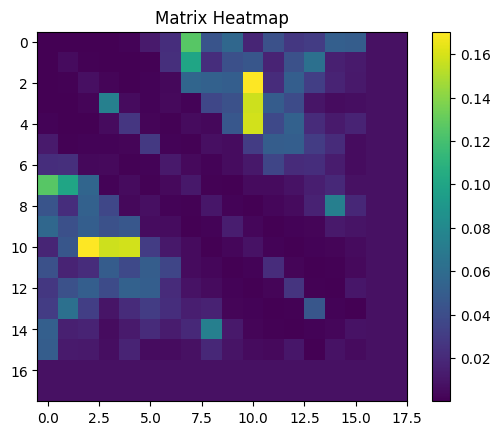

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_log_prob(logits, labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
####################### TELEMETRY ###########################################
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = EsmModel.from_pretrained(model_checkpoint).to(device)
model.eval()
#ref_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

sequences = [
    'MVLSPADKTNVKAAWG',
    'MVLSPADKTNVKAAW',
    #'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH',
    #'ADKGTVWMLFQHSERPIVNRTFYCHQWASLDZMPKTNEGGWPLAKJXSVBMCLNFDYAHTRBGUKSPVIQWEMRXOZUFLPDCNQYHTKGJWVABZMSLEKRFXPIAQNWYTGOJSUVMCZKLDHPRETBWFGYAL'
]
max_length = 20 #max([len(seq) for seq in sequences])

#Tokenize and pad/truncate the sequences
tokens = tokenizer(sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt").to(device)
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]
#inputs = tokenizer(sequences, return_tensors="pt", add_special_tokens=False, padding='max_length', max_length=max_length).to(device)

with torch.no_grad():
  #outputs = model(**inputs)
  #print(outputs.positions)
  contacts = model.predict_contacts(tokens=input_ids, attention_mask=attention_mask).cpu().numpy()
  outputs = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
  print(f"Outputs shape: {outputs.shape}")
  print(f"Contacts shape: {contacts.shape}")
  plt.imshow(contacts[0,:,:], cmap='viridis', interpolation='nearest')
  plt.colorbar()  # Show color scale
  plt.title('Matrix Heatmap')
  plt.show()

  # print(outputs.logits.shape)
  # print(get_log_prob(outputs.logits, input_ids))

  # del model
  #del ref_model
  ####################### TELEMETRY ###########################################


In [ ]:
# DPO Functions
import torch.nn.functional as F

# def get_log_prob(logits, labels):
#     log_probs = F.log_softmax(logits, dim=-1)
#     return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

def get_log_prob(logits, labels, attention_mask):
    log_probs = F.log_softmax(logits, dim=-1)
    gathered_and_apply_attention = torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1) * attention_mask
    sequence_lengths = (labels != tokenizer.pad_token_id).sum(dim=-1)
    return gathered_and_apply_attention.sum(dim=-1) / sequence_lengths.float()

def calculate_DPO_loss(model_prefered_logprob, model_disprefered_logprob,
                       ref_prefered_logprob, ref_disprefered_logprob, strengths,
                       beta=1.0, ipo=True, label_smoothing=0.0, reference_free=False):
    beta = beta * strengths
    prefered_relative_logprob = model_prefered_logprob - ref_prefered_logprob
    disprefered_relative_logprob = model_disprefered_logprob - ref_disprefered_logprob

    pi_logratios = model_prefered_logprob - model_disprefered_logprob
    ref_logratios = ref_prefered_logprob - ref_disprefered_logprob
    # losses = -F.logsigmoid(beta * logits) = -F.logsigmoid(beta * (pi_logratios - ref_logratios))

    if(reference_free):
      ref_logratios = 0.0

    logits = pi_logratios - ref_logratios  # also known as h_{\pi_\theta}^{y_w,y_l}
    reward_accuracies = (prefered_relative_logprob > disprefered_relative_logprob).float().mean(dim=-1)
    reward_margins = (prefered_relative_logprob - disprefered_relative_logprob).mean(dim=-1)

    if(ipo):
        loss = (logits - 1/(2 * beta)) ** 2  # Eq. 17 of https://arxiv.org/pdf/2310.12036v2.pdf
        loss = loss.mean()
    else:
        loss = -F.logsigmoid(beta * logits) * (1 - label_smoothing) - F.logsigmoid(-beta * logits) * label_smoothing # -F.logsigmoid(beta * (prefered_relative_logprob - disprefered_relative_logprob)) #
        loss = loss.mean()

    return loss, prefered_relative_logprob.mean(dim=-1), disprefered_relative_logprob.mean(dim=-1), reward_accuracies, reward_margins, pi_logratios, ref_logratios

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
from tqdm import tqdm
from Levenshtein import distance

def collate_fn(batch, device):
    # Unpack the batch
    prefered_ids, disprefered_ids, prefered_mask, disprefered_mask, strengths = zip(*batch)

    # Stack the tensors
    prefered_ids = torch.stack(prefered_ids).to(device)
    disprefered_ids = torch.stack(disprefered_ids).to(device)
    prefered_mask = torch.stack(prefered_mask).to(device)
    disprefered_mask = torch.stack(disprefered_mask).to(device)
    strengths = torch.tensor(strengths).to(device)

    return {'prefered_ids': prefered_ids,
            'disprefered_ids': disprefered_ids,
            'prefered_mask': prefered_mask,
            'disprefered_mask': disprefered_mask,
            'strengths': strengths}

class TMLibrary(Dataset):
    def __init__(self, file_path, tokenizer, max_length, split):
        self.data = pd.read_csv(file_path)
        combination_indexes = list(combinations(range(len(self.data)), 2))
        combination_indexes, absolute_differences, num_samples = self.filter_combination_indexes(combination_indexes, split)
        self.num_seqs = len(self.data)
        self.observed_seqs = set()
        self.num_samples = num_samples
        self.combination_indexes = iter(combination_indexes)
        self.max_abs_diff = np.max(absolute_differences)
        self.min_abs_diff = np.min(absolute_differences)
        self.tokenizer = tokenizer
        self.tokenized = self.tokenizer(self.data['aa_seq'].tolist(), padding=True, return_tensors="pt", max_length=max_length, truncation=True )

    def filter_combination_indexes(self, index_pairs, split):

        # preare dataframe
        index1, index2 = zip(*index_pairs)
        scores1 = self.data['avg_induction_score'].values[np.array(index1)]
        scores2 = self.data['avg_induction_score'].values[np.array(index2)]
        sequence1 = self.data['aa_seq'].values[np.array(index1)]
        sequence2 = self.data['aa_seq'].values[np.array(index2)]

        abs_diff = np.abs(scores1 - scores2)
        normalized_abs_diff = (abs_diff - np.min(abs_diff)) / (np.max(abs_diff) - np.min(abs_diff))

        df = pd.DataFrame(
            {
              'index1': index1,
              'index2': index2,
              'score1': scores1,
              'score2': scores2,
              'abs_diff': abs_diff,
              'normalized_abs_diff': normalized_abs_diff,
              'sequence1':sequence1,
              'sequence2':sequence2,
            })

        #df['lev_distance'] = df.apply(lambda row: distance(row['sequence1'], row['sequence2']), axis=1)
        #df['normalized_lev_distance'] = (df['lev_distance'] - np.min(df['lev_distance'])) / (np.max(df['lev_distance']) - np.min(df['lev_distance']))

        threshold = 3.055293866

        df = df[(df['score1'] >= threshold) | (df['score2'] >= threshold)]

        # custom sort function
        def custom_sort(row):
            return row['abs_diff'] # row['normalized_lev_distance'] +

        if(split == 'none'):
          df_sorted = df.iloc[df.apply(custom_sort, axis=1).argsort()[::-1]]
        else:
          df_sorted = df.sample(frac=1).reset_index(drop=True)

        # Extract the selected pairs and differences
        selected_pairs = list(zip(df_sorted['index1'], df_sorted['index2']))

        filtered_abs_diff = df_sorted['normalized_abs_diff'].tolist()
        num_samples = len(selected_pairs)
        print(f'num_samples: {num_samples}')

        return selected_pairs, filtered_abs_diff, num_samples


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        pair = next(self.combination_indexes)
        self.observed_seqs.add(pair[0])
        self.observed_seqs.add(pair[1])
        if(len(self.observed_seqs) == self.num_seqs):
          print("1 pass through sequences completed!")
          self.observed_seqs = set()

        score_1 = self.data.iloc[pair[0]]['avg_induction_score']
        score_2 = self.data.iloc[pair[1]]['avg_induction_score']

        if(score_1 > score_2):
          preferred_ids = self.tokenized['input_ids'][pair[0]]
          preferred_mask = self.tokenized['attention_mask'][pair[0]]
          disprefered_ids = self.tokenized['input_ids'][pair[1]]
          disprefered_mask = self.tokenized['attention_mask'][pair[1]]

        else:
          preferred_ids = self.tokenized['input_ids'][pair[1]]
          preferred_mask = self.tokenized['attention_mask'][pair[1]]
          disprefered_ids = self.tokenized['input_ids'][pair[0]]
          disprefered_mask = self.tokenized['attention_mask'][pair[0]]

        strengths = 1/(2*np.abs(np.log(score_1)-np.log(score_2)))
        # 1/(2*np.log(abs(score_1-score_2))) #(np.abs(score_1-score_2) - self.min_abs_diff) / (self.max_abs_diff - self.min_abs_diff)

        return preferred_ids, disprefered_ids, preferred_mask, disprefered_mask, strengths


In [ ]:
## Training loop
import wandb
P_MASK = 0.15

# Function to compute MLM loss for a batch of protein pairs
def compute_mlm_loss_batch(model, preferred_input_ids, preferred_mask, dispreferred_input_ids, dispreferred_mask):

    mask_token_id = tokenizer.mask_token_id
    pad_token_id = tokenizer.pad_token_id
    losses = None

    for input_ids, mask in [(preferred_input_ids, preferred_mask), (dispreferred_input_ids, dispreferred_mask)]:

        # Clone input IDs for labels
        labels = input_ids.clone()

        # Randomly mask 15% of the residues for each sequence in the batch
        masked_input_ids = input_ids.clone()
        for idx in range(input_ids.shape[0]):
            non_pad_indices = torch.where(input_ids[idx] != pad_token_id)[0]
            mask_indices = np.random.choice(non_pad_indices.cpu().numpy(), size=int(P_MASK * len(non_pad_indices)), replace=False)
            masked_input_ids[idx, mask_indices] = mask_token_id
            labels[idx, [i for i in range(input_ids.shape[1]) if i not in mask_indices]] = -100

        # Compute the MLM loss
        outputs = model(masked_input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        if(losses is None):
          losses = loss
        else:
          losses += loss

    return losses


def process_batch(batch, model, ref_model, beta, reg_weight, preference_weight):

    prefered_ids = batch['prefered_ids']
    disprefered_ids = batch['disprefered_ids']
    prefered_mask = batch['prefered_mask']
    disprefered_mask = batch['disprefered_mask']
    strengths = batch['strengths']

    model_prefered_output = model(prefered_ids, attention_mask=prefered_mask).logits
    model_disprefered_output = model(disprefered_ids, attention_mask=disprefered_mask).logits

    ref_prefered_output = ref_model(prefered_ids, attention_mask=prefered_mask).logits
    ref_disprefered_output = ref_model(disprefered_ids, attention_mask=disprefered_mask).logits

    model_prefered_log_prob = get_log_prob(model_prefered_output, prefered_ids, prefered_mask)
    model_disprefered_log_prob = get_log_prob(model_disprefered_output, disprefered_ids, disprefered_mask)

    ref_prefered_log_prob = get_log_prob(ref_prefered_output, prefered_ids, prefered_mask)
    ref_disprefered_log_prob = get_log_prob(ref_disprefered_output, disprefered_ids, disprefered_mask)

    loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins, pi_logratios,ref_logratios  = calculate_DPO_loss(
        model_prefered_log_prob, model_disprefered_log_prob,
        ref_prefered_log_prob, ref_disprefered_log_prob, strengths,
        beta=beta, label_smoothing=preference_weight
    )

    mlm_loss = compute_mlm_loss_batch(model, prefered_ids, prefered_mask, disprefered_ids, disprefered_mask)
    total_loss = loss + reg_weight * mlm_loss

    return total_loss, loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins, pi_logratios, ref_logratios

def validate(model, val_dataloader, ref_model, beta, reg_weight, preference_weight):
    model.eval()

    with torch.no_grad():
        #for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Validation")):
        batch = next(val_dataloader)
        total_loss, loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins, pi_logratios, ref_logratios = process_batch(batch, model, ref_model, beta, reg_weight, preference_weight)

        # val_batches += 1

    model.train()
    return total_loss, loss, prefered_relative_logprob , disprefered_relative_logprob, reward_accuracies, reward_margins


def train(model, ref_model, optimizer, scheduler, train_dataloader, val_dataloader, gradient_accumulation_steps=8, epochs=1, beta=0.1, reg_weight=1e-1, preference_weight=1e-1, print_interval=100):
    model.train()
    ref_model.eval()
    optimizer.zero_grad()
    for epoch in range(epochs):
        num_batches = len(train_dataloader)
        i = 0
        val_loss_running_avg = 0.0
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            total_loss, loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins, pi_logratios, ref_logratios = process_batch(batch, model, ref_model, beta, reg_weight, preference_weight)
            total_loss.backward()
            # if(scheduler):
            #   scheduler.step()
            i += 1
            if i % gradient_accumulation_steps == 0:
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                # Print gradients
                optimizer.step()
                optimizer.zero_grad()

            if(i % print_interval == 0):
              val_total_loss, val_loss, val_prefered_relative_logprob, val_disprefered_relative_logprob, val_reward_accuracies, val_reward_margins = validate(model, val_dataloader, ref_model, beta, reg_weight, preference_weight)
              val_loss_running_avg += val_loss
              scheduler.step(val_loss_running_avg/(i/print_interval))
              #print(f"Last computed lr: {scheduler.get_last_lr()}")
              wandb.log({
                'val_loss': val_loss,
                'val_prefered_relative_logprob': val_prefered_relative_logprob,
                'val_disprefered_relative_logprob': val_disprefered_relative_logprob,
                'val_reward_accuracy': val_reward_accuracies,
                'val_reward_margin': val_reward_margins,
              })


            wandb.log({
                'train_loss': loss,
                'prefered_relative_logprob': prefered_relative_logprob,
                'disprefered_relative_logprob': disprefered_relative_logprob,
                'reward_accuracy': reward_accuracies,
                'reward_margin': reward_margins,
            })




In [ ]:
from torch.distributions import Categorical
import random

def replace_with_mask(original_string, replacement_ratio, add_masks_distr_mean=2, max_length=50, snp=False):

    if(snp):
      num_replacements = 1
    else:
      num_replacements = int(len(original_string) * replacement_ratio)

    indices_to_replace = random.sample(range(len(original_string)), num_replacements)
    str_list = list(original_string)

    if(not snp):
      for index in indices_to_replace:
          str_list[index] = "<mask>"


      num_additional_masks = np.random.poisson(add_masks_distr_mean)
      for i in range(num_additional_masks):
          if(len(str_list) < max_length):
            add_position = random.choice(['beginning', 'end', 'none'])
            if add_position == 'beginning':
                str_list = ['<mask>'] + str_list
            elif( add_position == 'end'):
                str_list = str_list + ['<mask>']
            else:
              str_list = str_list
          else:
            break

    else:

      action = random.choice(['none', 'deletion', 'insertion', 'substitution'])
      if(action == 'deletion'):
        str_list[indices_to_replace[0]] = ''
      elif(action == 'insertion' and len(str_list) < max_length):
        str_list.insert(indices_to_replace[0], '<mask>')
      elif(action == 'substitution'):
        str_list[indices_to_replace[0]] = '<mask>'
      else:
        pass

    masked_sequence = ''.join(str_list)

    return masked_sequence

def replace_masks(masked_string, replacement_string):

    segments = masked_string.split("<mask>")
    result = ""
    for i, segment in enumerate(segments):
        result += segment
        if i < len(replacement_string):
            result += replacement_string[i]

    return result

# Generate TM
def generate(seq, model, tokenizer, device):
  model.eval()
  top_k = 5
  inputs = tokenizer(seq, return_tensors="pt").to(model.device)

  with torch.no_grad():
      logits = model(**inputs).logits
  mask_token_indices = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
  logits_at_masks = logits[0, mask_token_indices]

  # Apply top-k sampling
  top_k_logits, top_k_indices = logits_at_masks.topk(top_k, dim=-1)
  probabilities = torch.nn.functional.softmax(top_k_logits, dim=-1)
  predicted_indices = Categorical(probabilities).sample()
  predicted_token_ids = top_k_indices.gather(-1, predicted_indices.unsqueeze(-1)).squeeze(-1)

  aa_seq_masks = tokenizer.decode(predicted_token_ids, skip_special_tokens=True).replace(' ', '')

  return replace_masks(seq, aa_seq_masks)

def get_sequence_probs(sequences, model, tokenizer, max_length, device, batch_size=16):
    model.eval()
    all_probs = []

    with torch.no_grad():
        # Iterate through sequences in batches
        for i in range(0, len(sequences), batch_size):

            batch_sequences = sequences[i:i + batch_size]

            tokens = tokenizer(batch_sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
            input_ids = tokens["input_ids"].to(device)
            attention_mask = tokens["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_probs = get_log_prob(outputs.logits, input_ids, attention_mask)

            all_probs.append(batch_probs)

    # Concatenate the results from all batches
    return torch.cat(all_probs, dim=0)

def sample_lognormal_between_0_and_1(mean, sigma):
    while True:
        sample = np.random.lognormal(mean, sigma)
        if 0 < sample < 1:
            return sample


### Train model


In [ ]:
import torch
import torch.nn as nn
import re
from transformers import AdamW, get_cosine_schedule_with_warmup

class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=8):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.rank = rank

        # Initialize the low-rank matrices with Xavier uniform initialization
        self.A = nn.Parameter(torch.empty(rank, original_layer.weight.size(1)))
        self.B = nn.Parameter(torch.empty(original_layer.weight.size(0), rank))
        nn.init.xavier_uniform_(self.A)
        nn.init.xavier_uniform_(self.B)

        # Freeze original layer parameters
        for name, param in self.original_layer.named_parameters():
            param.requires_grad = False

    def forward(self, x):

        # Original layer forward pass
        original_output = self.original_layer(x)

        # Compute low-rank update
        low_rank_update = torch.matmul(torch.matmul(x, self.A.t()), self.B.t())

        return original_output + low_rank_update

def apply_lora_to_model(model, rank=8, num_layers=2, dropout_rate=0.0):
    for name, module in model.named_modules():
        if(check_layer(name, num_layers=num_layers) == -1 or check_layer(name, num_layers=num_layers) == 1):
          if isinstance(module, nn.Linear):
              parent, child_name = get_parent_and_child_by_name(model, name)
              setattr(parent, child_name, LoRALayer(module, rank=rank))
        else:
          for param in module.parameters():
            param.requires_grad = False
    return model

def get_parent_and_child_by_name(model, name):
    parts = name.split('.')
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    child_name = parts[-1]
    return parent, child_name

def set_dropout_rate(model, dropout_rate):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = dropout_rate
            #print(f"Set dropout rate to {dropout_rate} for layer {name}")
    return model

def check_layer(name, num_layers=2):

  # Define a regular expression pattern to match the word 'layer' followed by a dot and then a number
  pattern = r'\.layer\.(\d+)'
  # Search for the pattern in the string
  regexp_match = re.search(pattern, name)
  if(regexp_match is not None):
    return int(int(regexp_match.group(1)) > model_size[0]-(num_layers+1))
  else:
    return -1


def prepare_model(model, rank=8, num_layers=2, dropout_rate=0.0):

    # Apply LoRA to all Linear layers in the model
    model = apply_lora_to_model(model, rank=rank, num_layers=num_layers, dropout_rate=dropout_rate)

    for name, param in model.named_parameters():
      if('embeddings' in name):
        param.requires_grad = False
      if(not param.requires_grad):
        print(f"Layer {name} is frozen")

    model = set_dropout_rate(model, dropout_rate)

    return model

def freeze_model(model):
    # Freeze original layer parameters
    for name, param in model.named_parameters():
        param.requires_grad = False
    return model


# Custom cosine annealing scheduler with a minimum learning rate
class CosineAnnealingWithMinLRScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, num_warmup_steps, num_hold_steps, num_training_steps, init_lr=1e-3, min_lr=5e-4, last_epoch=-1):
        def lr_lambda(current_step):
            if current_step < num_warmup_steps:
                return (float(current_step) / float(max(1, num_warmup_steps)))
            if current_step < num_warmup_steps + num_hold_steps:
                return 1.0
            progress = float(current_step - (num_warmup_steps + num_hold_steps)) / float(max(1, num_training_steps - (num_warmup_steps + num_hold_steps)))
            cosine_decay_lr = 0.5 * (1 + torch.cos(torch.tensor(torch.pi * progress)))
            return max(min_lr/init_lr, cosine_decay_lr)

        super(CosineAnnealingWithMinLRScheduler, self).__init__(optimizer, lr_lambda, last_epoch)

In [ ]:
from functools import partial
from torch.optim.lr_scheduler import StepLR
import torch.optim.lr_scheduler as lr_scheduler

# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = prepare_model(EsmForMaskedLM.from_pretrained(model_checkpoint), rank=8, num_layers=model_size[0], dropout_rate=0.05).to(device)

# load state dict
model.load_state_dict(torch.load('/content/drive/MyDrive/p4.150M.JHP.8r.62r2.11202024.pth'))

ref_model = freeze_model(EsmForMaskedLM.from_pretrained(model_checkpoint)).to(device)


total_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in policy: {total_params(model)}")
print(f"Total number of trainable parameters in ref_model: {total_params(ref_model)}")

# hyperparameters
# previous best, dr = 0.05, wd = 5e-1
lr=5e-4
batch_size = 64
epochs = 1
beta = 1e0 # reward weight
max_length = 50
reg_weight = 5e-1 # mlm weight
gradient_accumulation_steps = 1
preference_weight = 0.0 # label smoothing parmaeter
print_interval = 10

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-3)

# gamma = 1.0 #(final_lr / lr) ** (1 / decay_period)
# print(f"Decaying lr with rate: {gamma}")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.90, patience=10,
                                                 threshold=1e-2, verbose=True, min_lr = 1e-5)
#torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataloader)*epochs, eta_min=1e-6)

dataset = TMLibrary(file_path="/content/tm_library_train_jhp.csv", tokenizer=tokenizer, max_length=max_length, split='train')
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, device=device))

val_dataset = TMLibrary(file_path="/content/tm_library_val_jhp.csv", tokenizer=tokenizer, max_length=max_length, split='val')
val_dataloader = itertools.cycle(torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, device=device)))

num_training_steps = epochs * len(train_dataloader)
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
num_hold_steps = int(0.0 * num_training_steps)  # 20% hold
min_lr = 1e-5  # Minimum learning rate you want to set

# scheduler = CosineAnnealingWithMinLRScheduler(optimizer, num_warmup_steps, num_hold_steps, num_training_steps, init_lr=lr, min_lr=min_lr)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Layer esm.embeddings.word_embeddings.weight is frozen
Layer esm.embeddings.position_embeddings.weight is frozen
Layer esm.encoder.layer.0.attention.self.query.original_layer.weight is frozen
Layer esm.encoder.layer.0.attention.self.query.original_layer.bias is frozen
Layer esm.encoder.layer.0.attention.self.key.original_layer.weight is frozen
Layer esm.encoder.layer.0.attention.self.key.original_layer.bias is frozen
Layer esm.encoder.layer.0.attention.self.value.original_layer.weight is frozen
Layer esm.encoder.layer.0.attention.self.value.original_layer.bias is frozen
Layer esm.encoder.layer.0.attention.output.dense.original_layer.weight is frozen
Layer esm.encoder.layer.0.attention.output.dense.original_layer.bias is frozen
Layer esm.encoder.layer.0.intermediate.dense.original_layer.weight is frozen
Layer esm.encoder.layer.0.intermediate.dense.original_layer.bias is frozen
Layer esm.encoder.layer.0.output.dense.original_layer.weight is frozen
Layer esm.encoder.layer.0.output.dense.or

<ipython-input-10-ebdccc5cef69>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/p4.150M.JHP.8r.62r2.11202024.pth')

Total number of trainable parameters in policy: 2864625
Total number of trainable parameters in ref_model: 0
num_samples: 1844682
num_samples: 17666


In [ ]:
print(model)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.05, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (key): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (value): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (dropout): Dropout(p=0.05, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Lo

In [ ]:
#0.418, 1627
wandb.login()
wandb.init()

train(model, ref_model, optimizer, scheduler, train_dataloader, val_dataloader, gradient_accumulation_steps=gradient_accumulation_steps, epochs=epochs, beta=beta, reg_weight=reg_weight, preference_weight=preference_weight, print_interval=print_interval)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


disprefered_relative_logprob,█▇▅▅▄▃▂▂▃▂▂▁▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▂▂▁▂▂▂▂
prefered_relative_logprob,█▇▅▆▃▄▆▄▄▄▃▄▄▂▃▃▄▃▃▂▂▂▂▂▃▂▃▃▂▃▂▄▂▁▄▂▁▄▂▂
reward_accuracy,▁▇▆▆██████████▇█▇████████▆█████▇███▇███▇
reward_margin,▁▅▆▆▆▆▆▅▅▆▆▆▇▆▆▆▆▅▆▆▇▇▆▆▆▇▇▅▇▆▆▇▆▆▆▅▆▇█▆
train_loss,█▄▄▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_disprefered_relative_logprob,█▇▇▄▃▂▃▃▃▃▂▂▁▂▂▂▂▂▁▂▁▁▁▁▂▁▂▂▂▁▂▂▁▂▁▂▂▂▁▁
val_loss,▃▅█▅▂▃▅▇▅▅▅▂▅▄▁▃▅▅▂▃▃▅▃▃▄▆▅▅▄▆▄▅▄▂▃▄▂▃▃▇
val_prefered_relative_logprob,█▆▇▆▄▅▂▂▄▃▃▂▂▃▂▂▁▂▂▂▃▁▂▂▁▂▃▁▁▁▂▂▂▂▁▂▂▁▁▂
val_reward_accuracy,▃▄▁▆▆▆▇▇▅▆▆▆▇▄▆▄▃▅▆▇▅▅▂█▆▇▇▄▅▅▄▅▆▄█▇▆▅▅▅
val_reward_margin,▁▇▅▇▆▅█▆█▆▅▄▇▇▅▆▆▆▅▇▆▇▆▆▆▆▅▆▇▆▆▆▆▆▄▄▄▆▇▆
disprefered_relative_logprob,-3.6237


Epoch 1/1:   0%|          | 179/73713 [02:53<18:51:18,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   0%|          | 359/73713 [05:47<18:47:58,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   1%|          | 539/73713 [08:41<18:41:50,  1.09it/s]

1 pass through sequences completed!


Epoch 1/1:   1%|          | 585/73713 [09:26<19:06:53,  1.06it/s]

1 pass through sequences completed!


Epoch 1/1:   1%|          | 709/73713 [11:26<18:46:50,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   1%|          | 899/73713 [14:31<18:40:08,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1116/73713 [18:02<19:01:46,  1.06it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1159/73713 [18:43<18:37:50,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1359/73713 [21:58<18:32:56,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1549/73713 [25:03<18:38:39,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1635/73713 [26:26<18:57:44,  1.06it/s]

1 pass through sequences completed!


Epoch 1/1:   2%|▏         | 1729/73713 [27:57<18:28:53,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   3%|▎         | 1949/73713 [31:31<18:25:51,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   3%|▎         | 2096/73713 [33:54<18:35:51,  1.07it/s]

1 pass through sequences completed!


Epoch 1/1:   3%|▎         | 2109/73713 [34:06<18:25:21,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   3%|▎         | 2289/73713 [37:02<18:32:15,  1.07it/s]

1 pass through sequences completed!


Epoch 1/1:   3%|▎         | 2479/73713 [40:06<18:21:23,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   4%|▎         | 2582/73713 [41:46<19:31:47,  1.01it/s]

1 pass through sequences completed!


Epoch 1/1:   4%|▎         | 2639/73713 [42:41<18:15:22,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   4%|▍         | 3056/73713 [49:26<18:17:19,  1.07it/s]

1 pass through sequences completed!


Epoch 1/1:   5%|▍         | 3563/73713 [57:38<20:09:11,  1.03s/it]

1 pass through sequences completed!


Epoch 1/1:   5%|▌         | 3981/73713 [1:04:24<19:48:46,  1.02s/it]

1 pass through sequences completed!


Epoch 1/1:   6%|▌         | 4398/73713 [1:11:08<17:51:19,  1.08it/s]

1 pass through sequences completed!


Epoch 1/1:   7%|▋         | 4915/73713 [1:19:31<18:00:28,  1.06it/s]

1 pass through sequences completed!


Epoch 1/1:   7%|▋         | 5442/73713 [1:28:03<18:51:09,  1.01it/s]

1 pass through sequences completed!


Epoch 1/1:   8%|▊         | 5869/73713 [1:34:56<17:22:03,  1.09it/s]

1 pass through sequences completed!


Epoch 1/1:   8%|▊         | 6062/73713 [1:38:04<18:14:26,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/p4.150M.JHP.8r.62r2.11202024.pth") # 27%, 43019 steps, 1e-2 to 1e-7 lr, decay period 50000, batch size = 64*8

### Reset model

In [ ]:
import gc
import torch

try:
  del model
except:
  pass

try:
  del ref_model
except:
  pass

try:
  del dataset
except:
  pass

try:
  del train_dataloader
except:
  pass

try:
  del optimizer
except:
  pass

try:
  del scheduler
except:
  pass

torch.cuda.empty_cache()
gc.collect()


28782

In [ ]:
# reset
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 301383 KiB |  25245 MiB |  46183 GiB |  46183 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 301383 KiB |  25245 MiB |  46183 GiB |  46183 GiB |
|---------------------------------------------------------------------------|
| Requested memory      | 300800 KiB |  25091 MiB |  46014 GiB |  46014 GiB |
|---------------------------------------------------------------

### DeNovo Design

In [ ]:
top_k = 5
sorted_df = df.sort_values(by='avg_induction_score', ascending=False)
top_k_seqs = sorted_df['aa_seq'].tolist()[0:top_k]

In [ ]:
from collections import defaultdict
from tqdm import tqdm

df = pd.read_csv("/content/tm_library_annotated.csv")
seqs = df['aa_seq'].to_list()
sequence_lengths = [len(seq) for seq in seqs]
num_sequences = 5000
results_dict = defaultdict(list)

# parameters controlling rate of mutation
mean = -0.5  # Mean of the underlying normal distribution
sigma = 0.1  # Standard deviation of the underlying normal distribution
add_masks_distr_mean = 4 # Poisson mean

optimal_seqs = ['']

for i in tqdm(range(num_sequences)):


  seq = random.choice(top_k_seqs)#random.choice(seqs)
  replacement_ratio = sample_lognormal_between_0_and_1(mean, sigma)
  masked_seq = replace_with_mask(seq, replacement_ratio, add_masks_distr_mean=add_masks_distr_mean)
  generated_seq = generate(masked_seq, model, tokenizer, device)

  results_dict['original_sequence'].append(seq)
  results_dict['generated_sequence'].append(generated_seq)
  results_dict['original_logprobs'].append(get_sequence_probs(seq, model, tokenizer, max_length, device).cpu().item())
  results_dict['generated_logprobs'].append(get_sequence_probs(generated_seq, model, tokenizer, max_length, device).cpu().item())


 21%|██        | 1052/5000 [03:24<12:47,  5.14it/s]


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results_dict)
results_df.head(10)
improved_seqs = results_df[results_df['generated_logprobs'] > results_df['original_logprobs']].head(10)

best_seq_idx = results_df['generated_logprobs'].idxmax()
best_seq = results_df.loc[best_seq_idx]

best_overall = np.max(results_df[['original_logprobs']])
best_overall_series = results_df[(results_df['generated_logprobs'] == best_overall) | (results_df['original_logprobs'] == best_overall)]


best_overall_with_margin = best_overall - 0.0*np.abs(best_overall)
design_candidates = results_df[results_df['generated_logprobs'] >= best_overall_with_margin]

display(improved_seqs)
print("\n")
if(not design_candidates.empty):
  display(design_candidates)
else:
  print(f"No optimal generations. Best sequence {best_overall_series['original_sequence'].tolist()[0]} has logprob: {best_overall} and generated sequence {best_overall_series['generated_sequence'].tolist()[0]} with logprobs: {best_overall_series['generated_logprobs'].tolist()[0]}")
print("\n")
display(best_seq)

,original_sequence,generated_sequence,original_logprobs,generated_logprobs
43,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,LLIWLVVLGLLAVVFIICIVVALLWYCIWRLRQSDD,-1.116401,-1.054749
74,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,YWLIIVIVAVAAVAFIVLVVIGIILYKCKRCERRSE,-1.116401,-0.545060
105,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,LPVIVLWVGPVLAIVLIICLVIFIIWILRKRCGED,-1.116401,-1.002209
178,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,LILIVIVGVAVLVVVLIVVVIGIVLWYRYRARQVSE,-1.116401,-0.617959
195,IVGSATAGLVFVVAVVVIAIV,SPPRSPSASPSLVFVLAGVLIAIWVL,-1.948190,-1.869651
230,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,PPLIWLVLIVLVVVFVILVVLAIVLYKRWCRRSRED,-1.116401,-0.809571
262,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,LVWLWVIGVVLALVFILCIVIIILLYKICRRESVAD,-1.116401,-0.982417
334,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,VPPPLVLWVVGIVLLIVFLLLIVIAVLLYWRWRAERDGSRD,-1.116401,-1.041851
377,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,YLTVLIWLVGVLAAVLFIICIILAIWYIKRIRRRDDE,-1.116401,-0.913546
539,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD,MSLLLWVIGVVLAVVFIICIVVAFLYWIIKRRESDAR,-1.116401,-0.877841




No optimal generations. Best sequence VVYPCTALLLLCLFATIITYI has logprob: -0.2652149498462677 and generated sequence IVIVPLLLLLIICLLLLLMTLIVI with logprobs: -3.3433046340942383




,74
original_sequence,GLIWVVGPVLAVVFIICIVIAILLYKRKRAESD
generated_sequence,YWLIIVIVAVAAVAFIVLVVIGIILYKCKRCERRSE
original_logprobs,-1.116401
generated_logprobs,-0.54506


### Evolve sequence, must run above group

In [ ]:
df = pd.read_csv('/content/tm_library_annotated.csv')

top_k = -1
sorted_df = df.sort_values(by='avg_induction_score', ascending=False)
top_k_seqs = sorted_df['aa_seq'].tolist()[0:top_k]
non_tms = pd.read_csv("/content/100RandomHumanProteinSeqs.csv")
non_tm_seqs = non_tms['RandomSubstring'].to_list()

In [ ]:
def snp(seq, max_length=50):
  masked_seq = replace_with_mask(seq, replacement_ratio=None, add_masks_distr_mean=None, snp=True)
  generated_seq = generate(masked_seq, model, tokenizer, device)
  logprobs = get_sequence_probs(generated_seq, model, tokenizer, max_length, device).cpu().item()
  return generated_seq, logprobs

def evolve(seq):
  generation_indx = 1
  max_length = 50
  logprobs = get_sequence_probs(seq, model, tokenizer, max_length, device).cpu().item()
  print(f'Strting seqeunce: {seq} at generation {generation_indx} with logprobs: {logprobs}')
  #logprobs = -float('inf')
  while True:#logprobs > init_logprobs:
    candidate_seq, candidate_logprobs = snp(seq)
    if(candidate_logprobs > logprobs):
      seq = candidate_seq
      logprobs = candidate_logprobs
      generation_indx += 1
      print(f'Generation {generation_indx} -> sequence: {seq} with logprobs: {logprobs}')


evolve(top_k_seqs[1]) #



Strting seqeunce: VVYPCTALLLLCLFATIITYI at generation 1 with logprobs: -0.2652149498462677


KeyboardInterrupt: 

### Prob Regression


In [ ]:
sequences = [
      'MATKAAKAVNLFLGKVVTLAA', # Alpha A-1 Antitrypsin (E.coli)
      'MALWMRLLPLLALLALWGPDPAAA', # Insulin (Human)
      'CYIQNCPLG', # Oxytocin (Human),
      'HSQGTFTSDYSKYLDSRRAQDFVQWLMNT', # Glucagon (Human)
      'LAVGLTGGILLIVLAGLGAFW', # Really Good
      'VMGLLTGLIAAGVFLVIFGLL', # Really bad
      'ALATGACIVGILCLPLILLLV', # Moderately Good
      'VASSACLSLWTPVFWVLVLAF', # Best
  ]
max_length = 40
out = get_sequence_probs(sequences, model, tokenizer, max_length, device)
array = out.cpu().numpy()
np.set_printoptions(suppress=True)
print(array)

[-4.9444823 -2.5292277 -4.787419  -4.8089046 -2.4542227 -4.7486935
 -1.6402164 -0.0407017]


In [ ]:
df = pd.read_csv("/content/tm_library_test_jhp.csv")
#df = df[df['avg_induction_score'] >= 3.055293866]
seqs = df['aa_seq'].to_list()
scores = df['avg_induction_score'].to_list()
probs = get_sequence_probs(seqs, model, tokenizer, max_length, device).tolist()

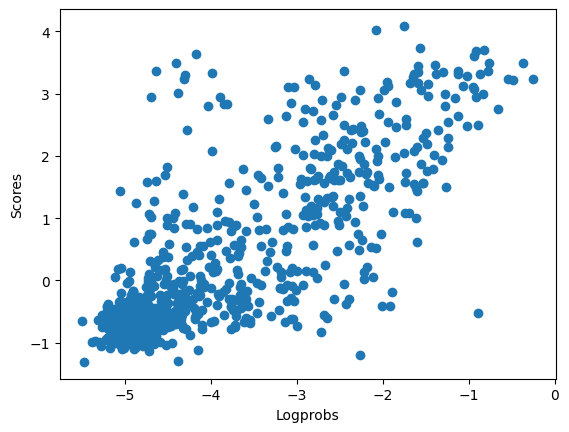

In [ ]:
import matplotlib.pyplot as plt

plt.plot(probs, np.log(scores), 'o')
plt.xlabel('Logprobs')
plt.ylabel('Scores')
plt.show()

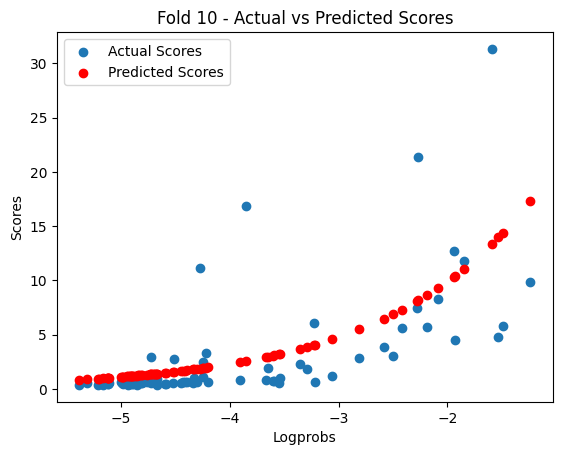

RMSE for Fold 10: 3.800650140914822
RRMSE for Fold 10: 1.3800612142219773
Average RMSE for all K: 5.277304370835094
Average RRMSE for all K: 1.4073446571592936


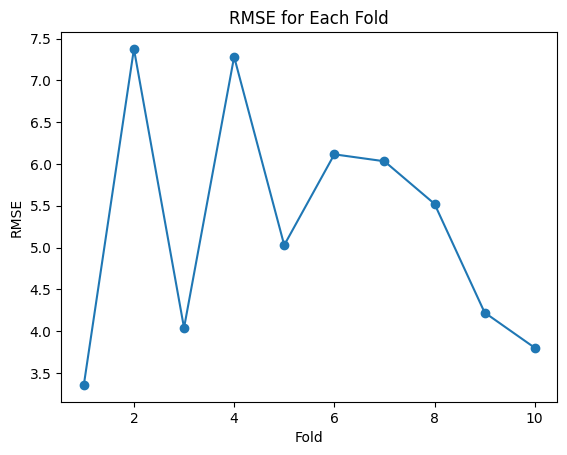

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Sample data
logprobs = np.array(probs)
scores = np.array(scores)

# Define the exponential regression model
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Initial guess for the parameters
initial_guess = [1, 0.1]

# Number of folds for K-Fold Cross Validation
n_splits = 10

# Initialize K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# List to store RMSE values for each fold
rmse_list = []
rrmse_list = []

# Perform K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kf.split(logprobs), start=1):
    logprobs_train, logprobs_test = logprobs[train_index], logprobs[test_index]
    scores_train, scores_test = scores[train_index], scores[test_index]

    # Fit the model
    params, covariance = curve_fit(exponential_model, logprobs_train, scores_train, p0=initial_guess)

    # Predict the scores on the test set
    predicted_scores = exponential_model(logprobs_test, *params)

    # Compute the RMSE
    rmse = np.sqrt(mean_squared_error(scores_test, predicted_scores))
    rmse_list.append(rmse)
    rrmse_list.append(rmse/np.average(scores_test))

    # Plot results for fold 27
    if fold == n_splits:
        plt.scatter(logprobs_test, scores_test, label='Actual Scores')
        plt.scatter(logprobs_test, predicted_scores, label='Predicted Scores', color='red')
        plt.xlabel('Logprobs')
        plt.ylabel('Scores')
        plt.legend()
        plt.title(f'Fold {fold} - Actual vs Predicted Scores')
        plt.show()

# Print RMSE for fold 27
print(f'RMSE for Fold {n_splits}: {rmse_list[n_splits-1]}')
print(f'RRMSE for Fold {n_splits}: {rrmse_list[n_splits-1]}')
print(f'Average RMSE for all K: {np.average(rmse_list)}')
print(f'Average RRMSE for all K: {np.average(rrmse_list)}')
# Plot RMSE for all folds
plt.plot(range(1, n_splits + 1), rmse_list, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold')
plt.show()



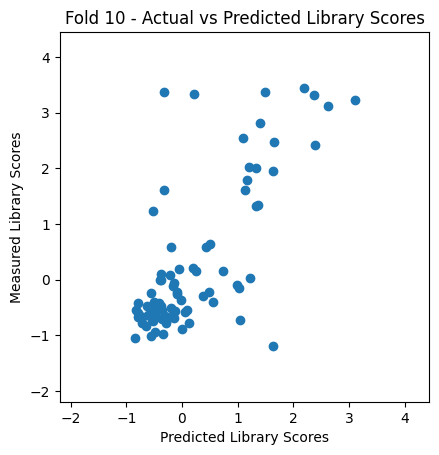



RMSE for Fold 10: 0.9049473973246617
RRMSE for Fold 10: 3.3653095284156627
R^2 for Fold 10: 0.5323707202942389


Average RMSE for all K: 0.7804135287605137
Average RRMSE for all K: 3.9123479231737925
Average R^2 for all K: 0.6185691902534909




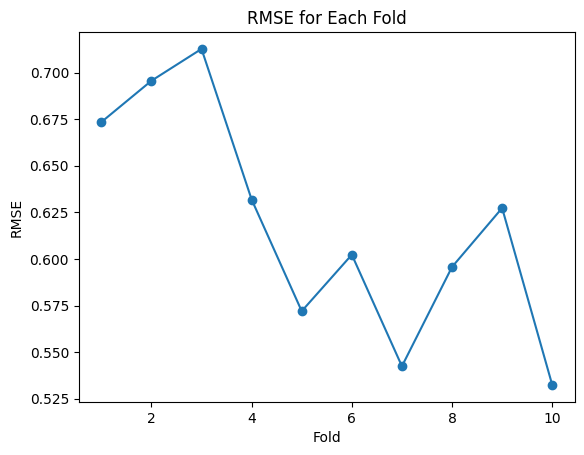

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

# Sample data
probs = np.array(probs) # probs
logscores = np.log(scores)    # logscores

# Define the linear regression model
def linear_model(x, a, b):
    return a * x + b

# Initial guess for the parameters
initial_guess = [1, 0]

# Number of folds for K-Fold Cross Validation
n_splits = 10

# Initialize K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# List to store RMSE values for each fold
rmse_list = []
rrmse_list = []
r2_list = []

# Perform K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kf.split(probs), start=1):
    probs_train, probs_test = probs[train_index], probs[test_index]
    logscores_train, logscores_test = logscores[train_index], logscores[test_index]

    # Fit the model
    params, covariance = curve_fit(linear_model, probs_train, logscores_train, p0=initial_guess)

    # Predict the log-scores on the test set
    predicted_logscores = linear_model(probs_test, *params)

    # Compute the RMSE
    rmse = np.sqrt(mean_squared_error(logscores_test, predicted_logscores))
    rmse_list.append(rmse)
    rrmse_list.append(rmse / np.average(logscores_test))

    # Compute the R^2 coefficient
    r2 = r2_score(logscores_test, predicted_logscores)
    r2_list.append(r2)

    # Plot results for the last fold
    if fold == n_splits:
        plt.scatter(predicted_logscores, logscores_test)
        #plt.scatter(probs_test, predicted_logscores, label='Predicted Logscores', color='red')
        plt.xlabel('Predicted Library Scores')
        plt.ylabel('Measured Library Scores')
        #plt.legend()

        min_value = min(min(predicted_logscores), min(logscores_test)) - 1
        max_value = max(max(predicted_logscores), max(logscores_test)) + 1

        #Set the range for both x and y axes to be the same
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)

        # Set identical ticks on both axes
        ticks = np.arange(int(min_value), int(max_value) + 1, 1)  # Adjust the increment (here 1) as needed
        plt.xticks(ticks)
        plt.yticks(ticks)

        # Set aspect ratio to be equal
        plt.gca().set_aspect('equal', adjustable='box')

        plt.title(f'Fold {fold} - Actual vs Predicted Library Scores')
        plt.show()

print("\n")
# Print RMSE for the last fold
print(f'RMSE for Fold {n_splits}: {rmse_list[n_splits-1]}')
print(f'RRMSE for Fold {n_splits}: {rrmse_list[n_splits-1]}')
print(f'R^2 for Fold {n_splits}: {r2_list[n_splits-1]}')
print("\n")
print(f'Average RMSE for all K: {np.average(rmse_list)}')
print(f'Average RRMSE for all K: {np.average(rrmse_list)}')
print(f'Average R^2 for all K: {np.average(r2_list)}')
print("\n")

# Plot RMSE for all folds
plt.plot(range(1, n_splits + 1), r2_list, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold')
plt.show()


### Negative Controls

In [ ]:
df = pd.read_csv('/content/tm_library_annotated.csv')
df_evolved = pd.read_csv('/content/efficient_mutation_g1_g2_tmd_only.csv')
neg_controls = pd.read_csv("/content/100RandomHumanProteinSeqs.csv")
neg_seqs = neg_controls['RandomSubstring'].to_list()

In [ ]:
# Negative controls
max_length = 50
out = get_sequence_probs(neg_seqs, model, tokenizer, max_length, device)
neg_array = out.cpu().numpy()

# Positive samples
pos_seqs = df['aa_seq'].to_list()
max_length = 50
out = get_sequence_probs(pos_seqs, model, tokenizer, max_length, device)
pos_array = out.cpu().numpy()

evolved_seqs = df_evolved['Subsequence'].to_list()
evolved_array = get_sequence_probs(evolved_seqs, model, tokenizer, max_length, device).cpu().numpy()

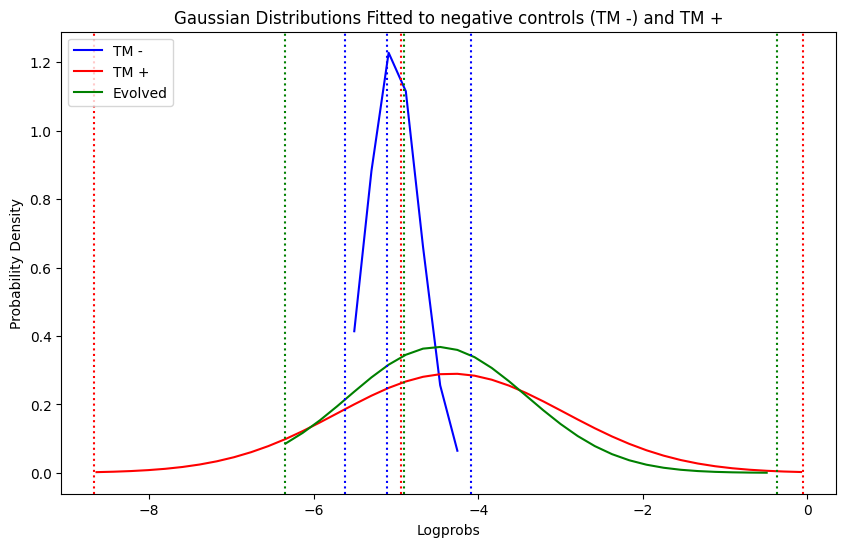

In [ ]:
# characterization of distributions
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Data for the two distributions
distribution_1 = [np.max(neg_array), np.min(neg_array), np.mean(neg_array), np.std(neg_array), np.median(neg_array)]
distribution_2 = [np.max(pos_array), np.min(pos_array), np.mean(pos_array), np.std(pos_array), np.median(pos_array)]
distribution_3 = [np.max(evolved_array), np.min(evolved_array), np.mean(evolved_array), np.std(evolved_array), np.median(evolved_array)]

# Extracting statistics
max1, min1, mean1, std1, median1 = distribution_1
max2, min2, mean2, std2, median2 = distribution_2
max3, min3, mean3, std3, median3 = distribution_3

# Generate points on the x axis
x = np.linspace(min(min1, min2) - 100, max(max1, max2) + 100, 1000)

# Calculate the Gaussian distributions
x1_filtered = x[(x >= min1) & (x <= max1)]
y1_filtered = norm.pdf(x1_filtered, mean1, std1)

x2_filtered = x[(x >= min2) & (x <= max2)]
y2_filtered = norm.pdf(x2_filtered, mean2, std2)

x3_filtered = x[(x >= min3) & (x <= max3)]
y3_filtered = norm.pdf(x3_filtered, mean3, std3)

# Plotting the distributions
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x1_filtered, y1_filtered, label='TM -', color='blue')
ax.plot(x2_filtered, y2_filtered, label='TM +', color='red')
ax.plot(x3_filtered, y3_filtered, label='Evolved', color='green')

# Marking max, min, and median on the plots
ax.axvline(max1, color='blue', linestyle='dotted')
ax.axvline(min1, color='blue', linestyle='dotted')
ax.axvline(median1, color='blue', linestyle='dotted')

ax.axvline(max2, color='red', linestyle='dotted')
ax.axvline(min2, color='red', linestyle='dotted')
ax.axvline(median2, color='red', linestyle='dotted')

ax.axvline(max3, color='green', linestyle='dotted')
ax.axvline(min3, color='green', linestyle='dotted')
ax.axvline(median3, color='green', linestyle='dotted')

# Adding labels, title, and legend
ax.set_xlabel('Logprobs')
ax.set_ylabel('Probability Density')
ax.set_title('Gaussian Distributions Fitted to negative controls (TM -) and TM +')
ax.legend()

plt.show()


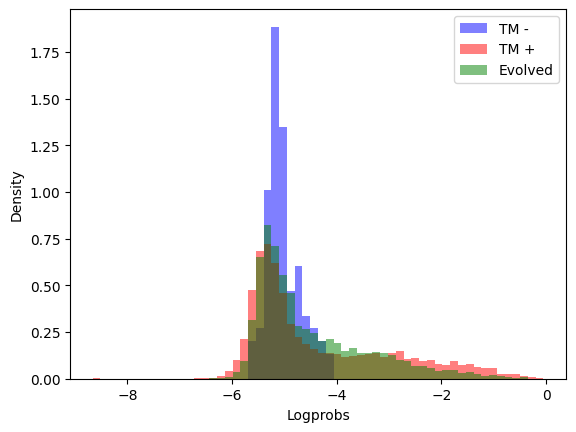

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
array1 = neg_array
array2 = pos_array
array3 = evolved_array

# Combine arrays to find the optimal binning
combined_array = np.concatenate([array1, array2, array3])

# Find optimal bin edges using numpy's histogram_bin_edges
bin_edges = np.histogram_bin_edges(combined_array, bins='auto')

# Plot normalized histograms with the optimal binning
plt.hist(array1, bins=bin_edges, alpha=0.5, color='blue', label='TM -', density=True)
plt.hist(array2, bins=bin_edges, alpha=0.5, color='red', label='TM +', density=True)
plt.hist(array3, bins=bin_edges, alpha=0.5, color='green', label='Evolved', density=True)

# Add labels and legend
plt.xlabel('Logprobs')
plt.ylabel('Density')
ax.set_title('Gaussian Distributions Fitted to negative controls (TM -) and TM + and evolved seqs')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
# Cosmic-forest-70

In [ ]:
07/25 - v1 (10%)
07/26 - v2 (8%)
07/26 - v1 (10%)
07/27 - v1 (6%, 50k steps)
07/31 - v1 (27%, 50k steps)

## Structure Prediction

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, EsmForMaskedLM, EsmForProteinFolding, AutoTokenizer, EsmConfig, EsmModel
import esm

model_size = (6, '8M')
model_checkpoint = f"facebook/esm2_t{model_size[0]}_{model_size[1]}_UR50D"
#model_checkpoint = "facebook/esmfold_v1"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

config = EsmConfig.from_pretrained(model_checkpoint)
print(config)

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

EsmConfig {
  "_name_or_path": "/tmp/facebook/esm2_t6_8M_UR50D",
  "architectures": [
    "EsmForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "emb_layer_norm_before": false,
  "esmfold_config": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 320,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "is_folding_model": false,
  "layer_norm_eps": 1e-05,
  "mask_token_id": 32,
  "max_position_embeddings": 1026,
  "model_type": "esm",
  "num_attention_heads": 20,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "rotary",
  "token_dropout": true,
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "use_cache": true,
  "vocab_list": null,
  "vocab_size": 33
}



cuda


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Outputs shape: torch.Size([1, 25, 320])
Contacts shape: (1, 23, 23)


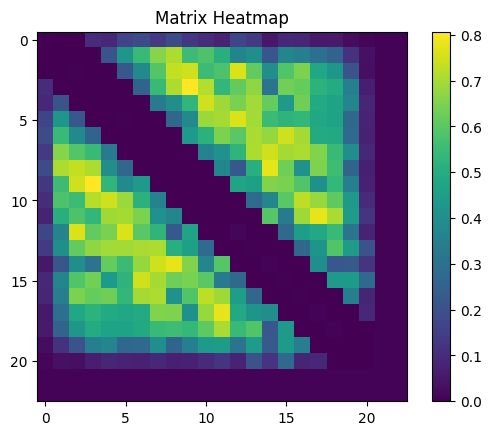

In [ ]:
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

esm = EsmModel.from_pretrained(model_checkpoint).to(device)
esm.eval()
esm.gradient_checkpointing_enable()
esm.use_cache = False

# sequences = [
#     'ALATGACIVGILCLPLILLLVALATGACIVGILCLPLILLLVALATGACI',
# ]
indx = 0
sequences = pd.read_csv('/content/tm_library_train.csv')['aa_seq'].to_list()[indx]
max_length = 25 #max([len(seq) for seq in sequences])

#Tokenize and pad/truncate the sequences
tokens = tokenizer(sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt").to(device)
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

with torch.no_grad():

  contacts = esm.predict_contacts(tokens=input_ids, attention_mask=attention_mask)
  outputs = esm(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
  print(f"Outputs shape: {outputs.shape}")
  print(f"Contacts shape: {contacts.cpu().numpy().shape}")
  plt.imshow(contacts.cpu().numpy()[0,:,:], cmap='viridis', interpolation='nearest')
  plt.colorbar()  # Show color scale
  plt.title('Matrix Heatmap')
  plt.show()


In [ ]:

'''returns shape (2, E_g_batch) where first row is x-index, second is y-index,
, E_g_batch is total number of edges in batch'''
def get_edge_index(contacts_batch, threshold=0.5):
  batch_indices, row_indices, col_indices = torch.where(contacts_batch > threshold)
  indices = torch.stack((col_indices, row_indices), dim=0)
  return indices

'''formats residue embeddings to node features for graph. Returns shape (N_g_batch, F) where N_g_batch is total number
nodes/contact residues in batch and F is feature dimension of each residue'''
def get_node_features(outputs_batch):

    reshaped_tensor = outputs_batch.view(-1, outputs_batch.size(2))
    batch_size = outputs_batch.size(0)
    num_elements_per_batch = outputs_batch.size(1)

    # Create a tensor indicating the batch index for each element
    batch_indices = torch.cat([torch.full((num_elements_per_batch,), i) for i in range(batch_size)])
    return reshaped_tensor, batch_indices

'''formats ESM output to graph'''
def format_to_graph_batch(contacts_batch, outputs_batch, threshold=0.5):
    edge_indices = get_edge_index(contacts_batch, 0)
    edge_attr = contacts_batch[:, edge_indices[0, :], edge_indices[1, :]]
    edge_attr = edge_attr.view(-1, 1)
    node_features, batch_indices = get_node_features(outputs_batch)
    return edge_indices, node_features, batch_indices, edge_attr

def get_graph(model, tokenizer, sequences, max_length, device=device):
    tokens = tokenizer(sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt").to(device)
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    eos_index = torch.where(input_ids[0] == tokenizer.eos_token_id)[0].item()
    non_special_indices = torch.arange(1, eos_index)
    with torch.no_grad():
        contacts = model.predict_contacts(tokens=input_ids, attention_mask=attention_mask)
        contacts = contacts[:, non_special_indices][:, :, non_special_indices]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        outputs = outputs[:, non_special_indices, :]
        #print(outputs.shape)

    return format_to_graph_batch(contacts.cpu(), outputs.cpu())

out = get_graph(esm, tokenizer, ['METDTLLLWVLLLWVPGSTGDASETGGSGGRLGSDKTHTCPPCPAPELLGGPSVFLFPPKPKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGVEVHNAKTKPREEQYNSTYRVVSVLTVLHQDWLNGKEYKCKVSNKALPAPIEKTISKAKGQPREPQVYTLPPSREEMTKNQVSLTCLVKGFYPSDIAVEWESNGQPENNYKTTPPVLDSDGSFFLYSKLTVDKSRWQQGNVFSCSVMHEALHNHYTQKSLSLSPGKGGGGSGGGGSGGGGSGEQKLISEEDLALATGACIVGILCLPLILLLVGGSGGLENLYFQSGSGGTLLEALTLASARGPLRKRSVPMAKAKPKFSISPDSLS'], max_length=512)
print(out[0].shape)

torch.Size([2, 131044])


In [ ]:
import torch
from torch_geometric.data import Dataset, Data, InMemoryDataset
import os
import pandas as pd
from tqdm import tqdm

class CustomGraphDatasetInMemory(InMemoryDataset):
    def __init__(self, root, file_path, model, tokenizer, max_length, transform=None, pre_transform=None):
        df = pd.read_csv(file_path)
        #df = df[df['avg_induction_score'] > 3.055293866]
        self.data = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.model = model
        self.max_length = max_length
        super(CustomGraphDatasetInMemory, self).__init__(root, transform, pre_transform)

        # Initialize data_list by loading processed data from disk, if it exists
        if os.path.exists(self.processed_paths[0]):
            self.data_list = torch.load(self.processed_paths[0])
        else:
            self.data_list = []

    @property
    def raw_file_names(self):
        # No raw files needed
        return []

    @property
    def processed_file_names(self):
        # Define where processed data will be stored
        return ['data.pt']

    def process(self):
        # Process the entire dataset and save it to disk
        data_list = []

        for idx in tqdm(range(len(self.data))):
            # Generate graph data using the model and tokenizer
            edge_indices, node_features, batch_indices, edge_attr = get_graph(
                self.model, self.tokenizer, [self.data['aa_seq'][idx]], self.max_length
            )

            # Graph-level label (e.g., for regression or classification)
            y = torch.log(torch.Tensor([self.data['avg_induction_score'][idx]]))

            # Create Data object
            graph_data = Data(x=node_features, edge_index=edge_indices, y=y, edge_attr=edge_attr)
            # Append to list
            data_list.append(graph_data)

        # Save the processed data list to disk without calling self.collate
        torch.save(data_list, self.processed_paths[0])

    def len(self):
        # Length is determined by the CSV data
        return len(self.data_list)

    def get(self, idx):
        # Return the graph data object at the given index
        return self.data_list[idx]


class CustomGraphDataset(Dataset):
    def __init__(self, root, file_path, model, tokenizer, max_length, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(root, transform, pre_transform)
        df = pd.read_csv(file_path)
        #df = df[df['avg_induction_score'] > 3.055293866]
        self.data = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.model = model
        self.max_length = max_length

    @property
    def raw_file_names(self):
        # No raw file, as we're generating data dynamically
        return []

    @property
    def processed_file_names(self):
        # No processed file, as we're generating data dynamically
        return []

    def len(self):
        # Define the number of graphs in the dataset
        return len(self.data)  # For example, 10 graphs

    def get(self, idx):
        edge_indices, node_features, batch_indices, edge_attr = get_graph(self.model, self.tokenizer, [self.data['aa_seq'][idx]], self.max_length, device)
        #edge_attr = torch.ones((edge_index.size(1), 1))  # One scalar feature per edge
        # Graph-level label (e.g., for binary classification)
        y = torch.Tensor([self.data['avg_induction_score'][idx]])

        # Create and return the Data object for the graph
        data = Data(x=node_features, edge_index=edge_indices, y=y, edge_attr=edge_attr)

        return data


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.utils import degree

class MPNNLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(MPNNLayer, self).__init__(aggr='sum')  # "Add" aggregation (sum messages)

        # MLP to compute messages
        self.message_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # MLP to update node features
        self.update_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        # Start the message passing process
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # Concatenate the node features of neighbors (x_j) with the edge features
        return self.message_mlp(torch.cat([x_j, edge_attr], dim=-1))

    def update(self, aggr_out, x):
        # Concatenate the aggregated messages with the original node features
        return self.update_mlp(torch.cat([x, aggr_out], dim=-1))


class MPNN(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, num_layers):
        super(MPNN, self).__init__()
        # Project node features and edge features initially
        self.node_proj = nn.Linear(node_dim, hidden_dim)
        self.edge_proj = nn.Linear(edge_dim, hidden_dim)

        # Stack of MPNN layers
        self.layers = nn.ModuleList([MPNNLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers)])
        self.readout = global_add_pool
        self.regression_head = nn.Linear(hidden_dim, 1)  # For graph-level regression or classification

    def forward(self, x, edge_index, edge_attr, batch):
        # Project node features and edge features to hidden_dim initially
        x = self.node_proj(x)
        edge_attr = self.edge_proj(edge_attr)

        # Pass through MPNN layers
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr)

        # Global pooling to get graph-level representation
        graph_embedding = self.readout(x, batch)

        # Graph-level classification or regression output
        return self.regression_head(graph_embedding)


In [ ]:
from torch_geometric.loader import DataLoader
import torch.optim as optim
import shutil

output_path = '/content/train'
if(os.path.exists(output_path)):
    shutil.rmtree(output_path)
    print(f"Directory '{output_path}' removed successfully.")
else:
    print(f"Directory '{output_path}' does not exist.")

output_path = '/content/test'
if(os.path.exists(output_path)):
    shutil.rmtree(output_path)
    print(f"Directory '{output_path}' removed successfully.")
else:
    print(f"Directory '{output_path}' does not exist.")

output_path = '/content/val'
if(os.path.exists(output_path)):
    shutil.rmtree(output_path)
    print(f"Directory '{output_path}' removed successfully.")
else:
    print(f"Directory '{output_path}' does not exist.")

# Create the DataLoader (from the custom dataset created earlier)
val_dataset = CustomGraphDatasetInMemory(root=os.getcwd() + '/val', file_path=os.getcwd() + '/tm_library_val.csv', tokenizer=tokenizer, model=esm, max_length=40)
test_dataset = CustomGraphDatasetInMemory(root=os.getcwd() + '/test', file_path=os.getcwd() + '/tm_library_test.csv', tokenizer=tokenizer, model=esm, max_length=40)
train_dataset = CustomGraphDatasetInMemory(root=os.getcwd() + '/train', file_path=os.getcwd() + '/tm_library_train.csv', tokenizer=tokenizer, model=esm, max_length=40)


Processing...
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Directory '/content/train' does not exist.
Directory '/content/test' does not exist.
Directory '/content/val' does not exist.


100%|██████████| 266/266 [00:04<00:00, 59.80it/s]
Done!
<ipython-input-41-6a60a6f1eeea>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data_list = torch.load(self.pr

In [ ]:
import itertools
from tqdm import tqdm
import torch.optim as optim
from torch_geometric.loader import DataLoader

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparams
batch_size = 64
lr = 1e-3

# Instantiate the model, loss function, and optimizer
model = MPNN(node_dim=320, edge_dim=1, hidden_dim=16, num_layers=4).to(device)

total_trainable_params  = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e0)
criterion = nn.MSELoss()  # Binary classification

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Training loop
num_epochs = 10
print_interval = 10 # Print every 100 epochs

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs*len(train_loader), eta_min=1e-6)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    print_count = 0

    # Training phase
    for idx, batch in enumerate(tqdm(train_loader)):
        batch = batch.to(device)  # Move batch data to the appropriate device

        optimizer.zero_grad()  # Zero gradients
        output = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)  # Forward pass
        #print(output.view(-1))
        loss = criterion(output.view(-1), batch.y.float())  # Calculate loss
        loss.backward()  # Backpropagation

        optimizer.step()  # Update model parameters
        scheduler.step()

        running_train_loss += loss.item()  # Accumulate training loss

        if(idx % print_interval == 0):
          # Validation phase
          model.eval()  # Set model to evaluation mode
          running_val_loss = 0.0
          with torch.no_grad():  # Disable gradient computation
              for val_batch in val_loader:  # Use `val_batches` to limit validation steps
                  val_batch = val_batch.to(device)  # Get next batch from validation loader
                  val_output = model(val_batch.x, val_batch.edge_index, val_batch.edge_attr, val_batch.batch)
                  val_loss = criterion(val_output.view(-1), val_batch.y.float())
                  running_val_loss += val_loss.item()  # Accumulate validation loss
          avg_val_loss = running_val_loss / len(val_loader)
          print(f"Batch {idx+1}/{len(train_loader)}, Train Loss: {running_train_loss / (idx+1):.4f}, Val Loss: {avg_val_loss:.4f}")
          model.train()


Total trainable parameters: 11585


  6%|▌         | 4/72 [00:00<00:01, 36.13it/s]

Batch 1/72, Train Loss: 9.2988, Val Loss: 1.8733


 15%|█▌        | 11/72 [00:00<00:01, 44.07it/s]

Batch 11/72, Train Loss: 2.4119, Val Loss: 2.0328


 43%|████▎     | 31/72 [00:00<00:00, 47.72it/s]

Batch 21/72, Train Loss: 2.0539, Val Loss: 1.7220
Batch 31/72, Train Loss: 1.8368, Val Loss: 1.7078


 61%|██████    | 44/72 [00:00<00:00, 49.18it/s]

Batch 41/72, Train Loss: 1.8227, Val Loss: 1.8859
Batch 51/72, Train Loss: 1.7599, Val Loss: 1.5016


 99%|█████████▊| 71/72 [00:01<00:00, 49.31it/s]

Batch 61/72, Train Loss: 1.7058, Val Loss: 1.7022
Batch 71/72, Train Loss: 1.6676, Val Loss: 1.3729


 15%|█▌        | 11/72 [00:00<00:01, 45.89it/s]

Batch 1/72, Train Loss: 1.4676, Val Loss: 1.6227
Batch 11/72, Train Loss: 1.1724, Val Loss: 1.5093


 43%|████▎     | 31/72 [00:00<00:00, 49.35it/s]

Batch 21/72, Train Loss: 1.2423, Val Loss: 1.5403
Batch 31/72, Train Loss: 1.2813, Val Loss: 1.5020


 71%|███████   | 51/72 [00:01<00:00, 49.13it/s]

Batch 41/72, Train Loss: 1.2562, Val Loss: 1.6975
Batch 51/72, Train Loss: 1.2491, Val Loss: 1.2730


 89%|████████▉ | 64/72 [00:01<00:00, 49.60it/s]

Batch 61/72, Train Loss: 1.2221, Val Loss: 1.3465
Batch 71/72, Train Loss: 1.2089, Val Loss: 1.4942

100%|██████████| 72/72 [00:01<00:00, 49.82it/s]


  6%|▌         | 4/72 [00:00<00:01, 39.24it/s]

Batch 1/72, Train Loss: 1.0636, Val Loss: 1.3806


 29%|██▉       | 21/72 [00:00<00:01, 45.97it/s]

Batch 11/72, Train Loss: 1.1668, Val Loss: 1.2218
Batch 21/72, Train Loss: 1.1198, Val Loss: 1.1943


 57%|█████▋    | 41/72 [00:00<00:00, 49.47it/s]

Batch 31/72, Train Loss: 1.0854, Val Loss: 1.1370
Batch 41/72, Train Loss: 1.0859, Val Loss: 1.5267


 85%|████████▍ | 61/72 [00:01<00:00, 50.74it/s]

Batch 51/72, Train Loss: 1.1140, Val Loss: 1.3996
Batch 61/72, Train Loss: 1.1169, Val Loss: 1.2007


100%|██████████| 72/72 [00:01<00:00, 50.74it/s]


Batch 71/72, Train Loss: 1.1181, Val Loss: 1.3770


  7%|▋         | 5/72 [00:00<00:01, 43.67it/s]

Batch 1/72, Train Loss: 1.9702, Val Loss: 1.2531


 25%|██▌       | 18/72 [00:00<00:01, 51.68it/s]

Batch 11/72, Train Loss: 1.2788, Val Loss: 1.7251
Batch 21/72, Train Loss: 1.1707, Val Loss: 1.2023


 53%|█████▎    | 38/72 [00:00<00:00, 52.55it/s]

Batch 31/72, Train Loss: 1.1284, Val Loss: 1.2415
Batch 41/72, Train Loss: 1.1241, Val Loss: 1.1854


 78%|███████▊  | 56/72 [00:01<00:00, 49.91it/s]

Batch 51/72, Train Loss: 1.1371, Val Loss: 1.3342
Batch 61/72, Train Loss: 1.1077, Val Loss: 1.1586


100%|██████████| 72/72 [00:01<00:00, 49.10it/s]


Batch 71/72, Train Loss: 1.0948, Val Loss: 1.4633


  6%|▌         | 4/72 [00:00<00:01, 36.40it/s]

Batch 1/72, Train Loss: 0.8078, Val Loss: 1.2977


 25%|██▌       | 18/72 [00:00<00:01, 50.54it/s]

Batch 11/72, Train Loss: 1.1178, Val Loss: 1.1735
Batch 21/72, Train Loss: 1.0881, Val Loss: 1.1499


 53%|█████▎    | 38/72 [00:00<00:00, 50.81it/s]

Batch 31/72, Train Loss: 1.0914, Val Loss: 1.3198


 61%|██████    | 44/72 [00:00<00:00, 48.23it/s]

Batch 41/72, Train Loss: 1.0784, Val Loss: 1.6163


 79%|███████▉  | 57/72 [00:01<00:00, 47.99it/s]

Batch 51/72, Train Loss: 1.0665, Val Loss: 1.3065


 96%|█████████▌| 69/72 [00:01<00:00, 51.16it/s]

Batch 61/72, Train Loss: 1.0722, Val Loss: 1.1480
Batch 71/72, Train Loss: 1.0586, Val Loss: 1.1768


 15%|█▌        | 11/72 [00:00<00:01, 44.76it/s]

Batch 1/72, Train Loss: 1.5963, Val Loss: 1.3117
Batch 11/72, Train Loss: 1.1160, Val Loss: 1.1019


 43%|████▎     | 31/72 [00:00<00:00, 49.93it/s]

Batch 21/72, Train Loss: 1.0561, Val Loss: 1.2860
Batch 31/72, Train Loss: 1.0674, Val Loss: 1.1712


 71%|███████   | 51/72 [00:01<00:00, 49.23it/s]

Batch 41/72, Train Loss: 1.0331, Val Loss: 1.4414
Batch 51/72, Train Loss: 1.0353, Val Loss: 1.4376


 99%|█████████▊| 71/72 [00:01<00:00, 49.43it/s]

Batch 61/72, Train Loss: 1.0281, Val Loss: 1.3925
Batch 71/72, Train Loss: 1.0413, Val Loss: 1.1042


 15%|█▌        | 11/72 [00:00<00:01, 44.35it/s]

Batch 1/72, Train Loss: 0.8369, Val Loss: 1.5394
Batch 11/72, Train Loss: 1.0699, Val Loss: 1.2744


 43%|████▎     | 31/72 [00:00<00:00, 49.04it/s]

Batch 21/72, Train Loss: 1.0159, Val Loss: 1.1704
Batch 31/72, Train Loss: 1.0646, Val Loss: 1.0710


 71%|███████   | 51/72 [00:01<00:00, 50.37it/s]

Batch 41/72, Train Loss: 1.0651, Val Loss: 1.0946
Batch 51/72, Train Loss: 1.0517, Val Loss: 1.1573


 99%|█████████▊| 71/72 [00:01<00:00, 50.78it/s]

Batch 61/72, Train Loss: 1.0364, Val Loss: 1.2079
Batch 71/72, Train Loss: 1.0320, Val Loss: 1.1881


 15%|█▌        | 11/72 [00:00<00:01, 47.32it/s]

Batch 1/72, Train Loss: 1.2992, Val Loss: 1.2586
Batch 11/72, Train Loss: 1.0574, Val Loss: 1.5042


 43%|████▎     | 31/72 [00:00<00:00, 49.88it/s]

Batch 21/72, Train Loss: 1.0550, Val Loss: 1.7376
Batch 31/72, Train Loss: 1.0297, Val Loss: 1.2555


 71%|███████   | 51/72 [00:01<00:00, 49.45it/s]

Batch 41/72, Train Loss: 1.0195, Val Loss: 1.1315
Batch 51/72, Train Loss: 1.0195, Val Loss: 1.2782


100%|██████████| 72/72 [00:01<00:00, 51.42it/s]


Batch 61/72, Train Loss: 1.0073, Val Loss: 1.1600
Batch 71/72, Train Loss: 1.0062, Val Loss: 1.1493


 15%|█▌        | 11/72 [00:00<00:01, 44.93it/s]

Batch 1/72, Train Loss: 1.3104, Val Loss: 1.1067
Batch 11/72, Train Loss: 0.9725, Val Loss: 1.3684


 33%|███▎      | 24/72 [00:00<00:00, 48.22it/s]

Batch 21/72, Train Loss: 0.9815, Val Loss: 1.1727
Batch 31/72, Train Loss: 1.0139, Val Loss: 1.1362


 71%|███████   | 51/72 [00:01<00:00, 49.04it/s]

Batch 41/72, Train Loss: 1.0299, Val Loss: 1.2221
Batch 51/72, Train Loss: 0.9897, Val Loss: 1.2233


 99%|█████████▊| 71/72 [00:01<00:00, 49.50it/s]

Batch 61/72, Train Loss: 0.9878, Val Loss: 1.1306
Batch 71/72, Train Loss: 0.9957, Val Loss: 1.4013


  6%|▌         | 4/72 [00:00<00:01, 37.03it/s]

Batch 1/72, Train Loss: 0.5964, Val Loss: 1.1919


 25%|██▌       | 18/72 [00:00<00:01, 51.47it/s]

Batch 11/72, Train Loss: 0.9048, Val Loss: 1.4257
Batch 21/72, Train Loss: 0.9471, Val Loss: 1.2649


 53%|█████▎    | 38/72 [00:00<00:00, 53.00it/s]

Batch 31/72, Train Loss: 0.9414, Val Loss: 1.2582
Batch 41/72, Train Loss: 0.9478, Val Loss: 1.2434


 81%|████████  | 58/72 [00:01<00:00, 53.86it/s]

Batch 51/72, Train Loss: 0.9759, Val Loss: 1.1459
Batch 61/72, Train Loss: 0.9909, Val Loss: 1.2221


100%|██████████| 72/72 [00:01<00:00, 49.91it/s]

Batch 71/72, Train Loss: 0.9923, Val Loss: 1.1015


In [ ]:
## evaluate on test set
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

y_pred = []
y_true = []

for batch in test_loader:

    batch = batch.to(device)
    with torch.no_grad():
      output = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).cpu().detach().numpy()
      batch_y = batch.y.cpu().detach().numpy()
      y_pred.append(output)
      y_true.append(batch_y)

y_pred = np.concatenate(y_pred, axis=0).flatten()
y_true = np.concatenate(y_true, axis=0).flatten()

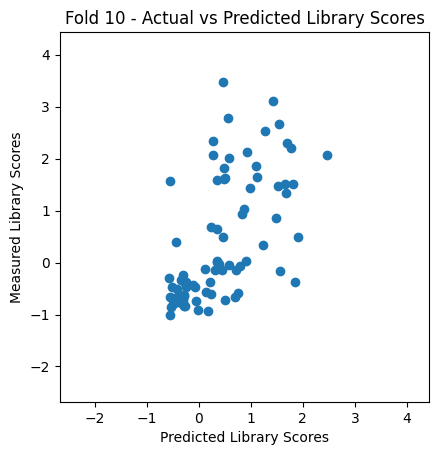



RMSE for Fold 10: 0.9445526599884033
RRMSE for Fold 10: 2.3461170196533203
R^2 for Fold 10: 0.37566977572390714


Average RMSE for all K: 1.0874583721160889
Average RRMSE for all K: 2.425351619720459
Average R^2 for all K: 0.3807119227601702




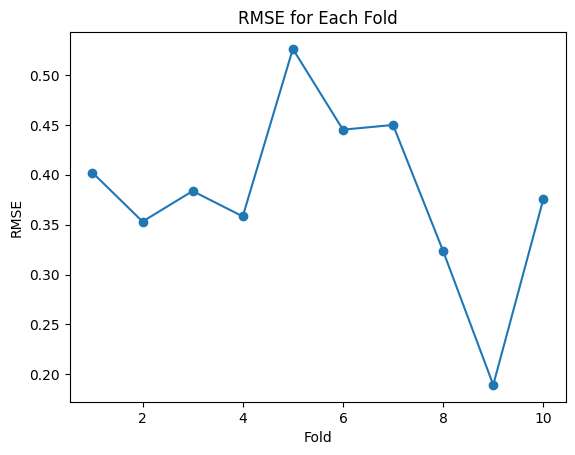

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

# Sample data
y_pred_arr = np.array(y_pred)
y_true_arr = np.array(y_true)

# Define the linear regression model
def linear_model(x, a, b):
    return a * x + b

# Initial guess for the parameters
initial_guess = [1, 0]

# Number of folds for K-Fold Cross Validation
n_splits = 10

# Initialize K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# List to store RMSE values for each fold
rmse_list = []
rrmse_list = []
r2_list = []

# Perform K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kf.split(y_pred_arr), start=1):
    y_pred_arr_train, y_pred_arr_test = y_pred_arr[train_index], y_pred_arr[test_index]
    y_true_arr_train, y_true_arr_test = y_true_arr[train_index], y_true_arr[test_index]

    # Fit the model
    params, covariance = curve_fit(linear_model, y_pred_arr_train, y_true_arr_train, p0=initial_guess)

    # Predict the log-scores on the test set
    predicted_scores = linear_model(y_pred_arr_test, *params)

    # Compute the RMSE
    rmse = np.sqrt(mean_squared_error(y_true_arr_test, predicted_scores))
    rmse_list.append(rmse)
    rrmse_list.append(rmse / np.average(y_true_arr_test))

    # Compute the R^2 coefficient
    r2 = r2_score(y_true_arr_test, predicted_scores)
    r2_list.append(r2)

    # Plot results for the last fold
    if fold == n_splits:
        plt.scatter(predicted_scores, y_true_arr_test)
        #plt.scatter(probs_test, predicted_logscores, label='Predicted Logscores', color='red')
        plt.xlabel('Predicted Library Scores')
        plt.ylabel('Measured Library Scores')
        #plt.legend()

        min_value = min(min(predicted_logscores), min(logscores_test)) - 1
        max_value = max(max(predicted_logscores), max(logscores_test)) + 1

        # Set the range for both x and y axes to be the same
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)

        # Set identical ticks on both axes
        ticks = np.arange(int(min_value), int(max_value) + 1, 1)  # Adjust the increment (here 1) as needed
        plt.xticks(ticks)
        plt.yticks(ticks)

        # Set aspect ratio to be equal
        plt.gca().set_aspect('equal', adjustable='box')

        plt.title(f'Fold {fold} - Actual vs Predicted Library Scores')
        plt.show()

print("\n")
# Print RMSE for the last fold
print(f'RMSE for Fold {n_splits}: {rmse_list[n_splits-1]}')
print(f'RRMSE for Fold {n_splits}: {rrmse_list[n_splits-1]}')
print(f'R^2 for Fold {n_splits}: {r2_list[n_splits-1]}')
print("\n")
print(f'Average RMSE for all K: {np.average(rmse_list)}')
print(f'Average RRMSE for all K: {np.average(rrmse_list)}')
print(f'Average R^2 for all K: {np.average(r2_list)}')
print("\n")

# Plot RMSE for all folds
plt.plot(range(1, n_splits + 1), r2_list, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold')
plt.show()


## ClinVar

In [ ]:
import pandas as pd
import csv

tm_df = pd.read_csv('/content/TM_Library_Expression_Retention (1).csv')
# count number of duplicates in one column
tm_df['group'] = tm_df['Seq ID'].apply(lambda x: x.split("_")[-1])
tm_df['Seq ID'] = tm_df['Seq ID'].apply(lambda x: x.split("_")[0])
tm_df.head()

,Seq ID,Retention Score Rep 1,Retention Score Rep 2,Average Retention Score,Induced Surface Score Rep 1,Induced Surface Score Rep 2,Average Induced Surface Score,Amino Acid Sequence,group
0,Q9H7M9,2.37,1.78,2.07,5.74,3.67,4.708204,ALATGACIVGILCLPLILLLV,g1
1,Q9BZD6,0.99,1.04,1.02,0.52,0.69,0.602900,VMGLLTGLIAAGVFLVIFGLL,g1
2,Q96H15,1.83,1.77,1.8,2.55,1.34,1.942436,LLMIIAPSLGFVLFALFVAFL,g1
3,P35916,1.4,1.6,1.5,1.05,1.28,1.168214,IVILVGTGVIAVFFWVLLLLI,g1
4,P22309,1.1,0.6,0.85,2.70,1.63,2.168671,VIGFLLAVVLTVAFITF,g1


In [ ]:
# Filter only rows where group is 'g1'
g1_df = tm_df[tm_df['group'] == 'g1']

# Find Seq IDs that occur only once in the 'g1' group
unique_g1_seqs = g1_df['Seq ID'].value_counts()
single_occurrence_seqs = set(unique_g1_seqs[unique_g1_seqs == 1].index.tolist())
print(f"Number of single occurrence sequences: {len(single_occurrence_seqs)}")
print(single_occurrence_seqs)

Number of single occurrence sequences: 1193
{'O95297', 'Q8N2Q7', 'Q5SQ64', 'P22309', 'Q6UXD5', 'Q8IZU8', 'P14778', 'Q13261', 'Q9BZG2', 'P0DTF9', 'Q16653', 'Q9Y3A6', 'Q9H1U4', 'P01911', 'Q8TDY8', 'Q9Y5Z0', 'O43506', 'P15509', 'Q9P2B2', 'Q16849', 'Q9NR96', 'Q15762', 'Q5VV43', 'P0C7U0', 'O43300', 'Q8TF66', 'Q96MS0', 'Q9H665', 'Q96J42', 'Q86VZ4', 'Q96IQ7', 'P13473', 'P27930', 'P54753', 'Q13477', 'Q16820', 'Q9ULT6', 'Q92637', 'A6NHS7', 'O75976', 'P10912', 'P19256', 'A0A0K2S4Q6', 'Q6GTX8', 'P33151', 'P04843', 'Q6UXZ3', 'P43146', 'P51511', 'O95196', 'Q6UX27', 'Q13634', 'Q01973', 'Q96PX8', 'P15812', 'Q50LG9', 'P01730', 'P19022', 'Q99466', 'O60462', 'P41217', 'Q86XT9', 'Q9H2E6', 'Q96LC7', 'P0C6S8', 'Q96JA1', 'Q8WWV6', 'P21709', 'P08637', 'P43631', 'Q5JRM2', 'Q9BY71', 'Q9Y5E9', 'Q9HB29', 'Q99706', 'O15399', 'P0DP72', 'Q8J025', 'Q8NFT8', 'P24394', 'P21860', 'Q8WVV5', 'Q9UJA9', 'P0DPE3', 'Q6PI73', 'Q96JP9', 'Q99795', 'Q13445', 'Q16651', 'Q8WUT4', 'P16662', 'P55287', 'P07333', 'Q15884', 'Q6UW88', '

In [ ]:
clinvar_df = pd.read_csv('/content/ClinVarTMDVariants (1).txt', delimiter='\t')  # or use sep='\t' for tab-delimited files
clinvar_df['seq_id'] = clinvar_df['seq_id'].apply(lambda x: x.split("_")[0])
clinvar_seqs = set(clinvar_df['seq_id'])
intersect = single_occurrence_seqs.intersection(clinvar_seqs)
print(f"Number of sequences in both sets: {len(intersect)}")
print(intersect)

Number of sequences in both sets: 388
{'O95297', 'Q8N2Q7', 'Q16653', 'Q9Y3A6', 'Q9Y5Z0', 'Q15762', 'Q16849', 'Q9NR96', 'P0C7U0', 'Q96MS0', 'Q96IQ7', 'P13473', 'P27930', 'P54753', 'Q9ULT6', 'Q16820', 'P10912', 'P04843', 'P51511', 'O95196', 'Q01973', 'P01730', 'O60462', 'Q8WWV6', 'P21709', 'Q8NFT8', 'Q9UJA9', 'Q96JP9', 'Q99795', 'Q8WUT4', 'P07333', 'P01133', 'P32926', 'P15813', 'Q15116', 'Q9P1W8', 'Q8TCW7', 'O60894', 'P16410', 'P07359', 'Q8WWF5', 'Q3SXY7', 'Q58EX2', 'Q29983', 'P19235', 'Q9BZW8', 'O43567', 'P11279', 'P12821', 'Q6P1J6', 'P13224', 'P14784', 'Q6PCB8', 'Q9H2U9', 'P19320', 'Q6UX41', 'Q5VWK5', 'P17643', 'Q9HBG7', 'Q96LA6', 'Q9H3N1', 'P98155', 'Q12836', 'Q01974', 'Q96J86', 'P11912', 'Q06136', 'Q6ZRP7', 'P24071', 'Q86SU0', 'Q9H6B4', 'Q495A1', 'P42262', 'Q96PZ7', 'O75460', 'Q9BVK6', 'O60602', 'O75325', 'O15455', 'Q14956', 'P29317', 'O60603', 'Q9NR97', 'Q9UK23', 'P50281', 'P29017', 'Q16827', 'Q12866', 'Q14114', 'Q07699', 'P54764', 'Q99650', 'P04629', 'Q9Y5Y7', 'P31431', 'Q8TDW7', '

In [ ]:
# get all the ones that are pathogenic
clinvar_all_relevant = clinvar_df[clinvar_df['seq_id'].isin(intersect)]
clinvar_all_relevant.to_csv("/content/clinvar_relevant_single_spanning.csv")
display(clinvar_all_relevant)
print(clinvar_all_relevant['ClinicalSignificance'].value_counts())
clinvar_pathogenic = clinvar_all_relevant[clinvar_all_relevant['ClinicalSignificance'].str.contains('pathogen', case=False, na=False)]
display(clinvar_pathogenic)
print(f"Number of annotated clinically relevant sequences: {len(clinvar_all_relevant)}")
print(f"Number of unique annotated clinically relevant uniprot ids: {len(clinvar_all_relevant)}")
print(f"Number of annotated pathogenic sequences: {len(clinvar_pathogenic)}")
print(f"Number of unique annotated pathogenic uniprot ids: {len(clinvar_pathogenic['seq_id'].unique())}")

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,position,seq_id
0,15057,single nucleotide variant,NM_000410.4(HFE):c.989G>T (p.Arg330Met),3077,HFE,HGNC:4886,Pathogenic,1,"Aug 01, 1999",111033558,...,"ACMG2021,ACMG2022",N,"OMIM:613609.0008,ClinGen:CA280947,UniProtKB:Q3...",1,18,26093443,G,T,989.0,Q30201
1,455491,single nucleotide variant,NM_000410.4(HFE):c.1010G>T (p.Gly337Val),3077,HFE,HGNC:4886,Uncertain significance,0,"Sep 01, 2021",751707198,...,"ACMG2021,ACMG2022",N,ClinGen:CA3666814,2,461190,26094417,G,T,1010.0,Q30201
2,765611,single nucleotide variant,NM_000410.4(HFE):c.978C>T (p.Phe326=),3077,HFE,HGNC:4886,Likely benign,0,"Sep 06, 2018",1581673132,...,"ACMG2021,ACMG2022",N,-,2,751536,26093432,C,T,978.0,Q30201
3,896216,single nucleotide variant,NM_000410.4(HFE):c.1006+14A>G,3077,HFE,HGNC:4886,Conflicting interpretations of pathogenicity,0,"Oct 09, 2022",201262562,...,"ACMG2021,ACMG2022",N,-,2,904395,26093474,A,G,1006.0,Q30201
4,954409,Deletion,NM_000410.4(HFE):c.968del (p.Gly323fs),3077,HFE,HGNC:4886,Uncertain significance,0,"Sep 13, 2022",766108842,...,"ACMG2021,ACMG2022",N,-,2,968749,26093420,TG,T,968.0,Q30201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5669,2266286,single nucleotide variant,NM_032027.3(TM2D1):c.376G>A (p.Ala126Thr),83941,TM2D1,HGNC:24142,Uncertain significance,0,"Feb 17, 2022",-1,...,-,N,-,2,2277763,62166669,C,T,376.0,Q9BX74
5670,2281658,single nucleotide variant,NM_002999.4(SDC4):c.458G>C (p.Gly153Ala),6385,SDC4,HGNC:10661,Uncertain significance,0,"Jun 30, 2022",-1,...,-,N,-,2,2299643,43956043,C,G,458.0,P31431
5671,2341566,single nucleotide variant,NM_002999.4(SDC4):c.512G>A (p.Arg171His),6385,SDC4,HGNC:10661,Uncertain significance,0,"Sep 06, 2022",-1,...,-,N,-,2,2346544,43955989,C,T,512.0,P31431
5672,2363198,single nucleotide variant,NM_052938.5(FCRL1):c.1004G>A (p.Gly335Glu),115350,FCRL1,HGNC:18509,Uncertain significance,0,"Sep 16, 2021",-1,...,-,N,-,2,2378343,157769875,C,T,1004.0,Q96LA6


ClinicalSignificance
Uncertain significance                          1365
Likely benign                                    703
Benign                                           210
Pathogenic                                       138
Conflicting interpretations of pathogenicity     119
Likely pathogenic                                 55
Benign/Likely benign                              51
Pathogenic/Likely pathogenic                      18
not provided                                       2
Uncertain risk allele; protective                  1
drug response                                      1
association                                        1
no interpretation for the single variant           1
Name: count, dtype: int64


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,position,seq_id
0,15057,single nucleotide variant,NM_000410.4(HFE):c.989G>T (p.Arg330Met),3077,HFE,HGNC:4886,Pathogenic,1,"Aug 01, 1999",111033558,...,"ACMG2021,ACMG2022",N,"OMIM:613609.0008,ClinGen:CA280947,UniProtKB:Q3...",1,18,26093443,G,T,989.0,Q30201
3,896216,single nucleotide variant,NM_000410.4(HFE):c.1006+14A>G,3077,HFE,HGNC:4886,Conflicting interpretations of pathogenicity,0,"Oct 09, 2022",201262562,...,"ACMG2021,ACMG2022",N,-,2,904395,26093474,A,G,1006.0,Q30201
5,1053984,single nucleotide variant,NM_000410.4(HFE):c.1006+1G>A,3077,HFE,HGNC:4886,Pathogenic/Likely pathogenic,1,"Feb 08, 2023",-1,...,"ACMG2021,ACMG2022",N,-,3,1065637,26093461,G,A,1006.0,Q30201
33,540830,Deletion,NM_206933.4(USH2A):c.15200del (p.Ile5067fs),7399,USH2A,HGNC:12601,Pathogenic/Likely pathogenic,1,"Jul 12, 2022",1295968274,...,-,N,-,2,556916,215807897,GA,G,15200.0,O75445
34,540832,single nucleotide variant,NM_206933.4(USH2A):c.15178T>C (p.Ser5060Pro),7399,USH2A,HGNC:12601,Conflicting interpretations of pathogenicity,1,"Jul 30, 2022",752377040,...,-,N,-,2,552090,215807920,A,G,15178.0,O75445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,363580,single nucleotide variant,NM_001281766.3(EPHA5):c.1748G>A (p.Gly583Glu),2044,EPHA5,HGNC:3389,Likely pathogenic,1,"May 13, 2016",1057520012,...,-,N,ClinGen:CA16603113,1,376701,66270137,C,T,1748.0,P54756
5018,2357115,single nucleotide variant,NM_006495.4(EVI2B):c.643A>G (p.Met215Val),2124,EVI2B,HGNC:3500,Conflicting interpretations of pathogenicity,0,"Dec 01, 2022",-1,...,-,N,-,2,2366525,29631985,T,C,643.0,P34910
5048,418321,single nucleotide variant,NM_002035.4(KDSR):c.879G>A (p.Gln293=),2531,KDSR,HGNC:4021,Pathogenic,1,"Jun 13, 2017",752611378,...,-,N,"ClinGen:CA8985991,OMIM:136440.0003",1,427791,61002490,C,T,879.0,Q06136
5140,1315000,single nucleotide variant,NM_005797.4(MPZL2):c.544C>T (p.Arg182Ter),10205,MPZL2,HGNC:3496,Likely pathogenic,1,"Dec 07, 2021",-1,...,-,N,-,2,1324734,118130809,G,A,544.0,O60487


Number of annotated clinically relevant sequences: 2665
Number of unique annotated clinically relevant uniprot ids: 2665
Number of annotated pathogenic sequences: 330
Number of unique annotated pathogenic uniprot ids: 87


In [ ]:
import pandas as pd
clinvar_ss = pd.read_csv('/content/clinvar_relevant_single_spanning.csv')
clinvar_ss.head(100)

,Unnamed: 0,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,...,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,position,seq_id
0,0,15057,single nucleotide variant,NM_000410.4(HFE):c.989G>T (p.Arg330Met),3077,HFE,HGNC:4886,Pathogenic,1,"Aug 01, 1999",...,"ACMG2021,ACMG2022",N,"OMIM:613609.0008,ClinGen:CA280947,UniProtKB:Q3...",1,18,26093443,G,T,989.0,Q30201
1,1,455491,single nucleotide variant,NM_000410.4(HFE):c.1010G>T (p.Gly337Val),3077,HFE,HGNC:4886,Uncertain significance,0,"Sep 01, 2021",...,"ACMG2021,ACMG2022",N,ClinGen:CA3666814,2,461190,26094417,G,T,1010.0,Q30201
2,2,765611,single nucleotide variant,NM_000410.4(HFE):c.978C>T (p.Phe326=),3077,HFE,HGNC:4886,Likely benign,0,"Sep 06, 2018",...,"ACMG2021,ACMG2022",N,-,2,751536,26093432,C,T,978.0,Q30201
3,3,896216,single nucleotide variant,NM_000410.4(HFE):c.1006+14A>G,3077,HFE,HGNC:4886,Conflicting interpretations of pathogenicity,0,"Oct 09, 2022",...,"ACMG2021,ACMG2022",N,-,2,904395,26093474,A,G,1006.0,Q30201
4,4,954409,Deletion,NM_000410.4(HFE):c.968del (p.Gly323fs),3077,HFE,HGNC:4886,Uncertain significance,0,"Sep 13, 2022",...,"ACMG2021,ACMG2022",N,-,2,968749,26093420,TG,T,968.0,Q30201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,880651,single nucleotide variant,NM_177986.5(DSG4):c.1933+12A>G,147409,DSG4,HGNC:21307,Conflicting interpretations of pathogenicity,0,"Feb 23, 2022",...,-,N,-,2,889353,28986348,A,G,1933.0,Q86SJ6
96,96,1220427,single nucleotide variant,NM_177986.5(DSG4):c.1934-250G>A,147409,DSG4,HGNC:21307,Benign,0,"Jun 19, 2021",...,-,N,-,2,1231756,28989165,G,A,1934.0,Q86SJ6
97,97,1235566,single nucleotide variant,NM_177986.5(DSG4):c.1934-199A>G,147409,DSG4,HGNC:21307,Benign,0,"Nov 10, 2018",...,-,N,-,2,1246903,28989216,A,G,1934.0,Q86SJ6
98,98,1271809,single nucleotide variant,NM_177986.5(DSG4):c.1934-183C>T,147409,DSG4,HGNC:21307,Benign,0,"Nov 11, 2018",...,-,N,-,2,1281091,28989232,C,T,1934.0,Q86SJ6


In [ ]:
import asyncio
import aiohttp
import nest_asyncio
import pandas as pd

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

async def fetch_fasta(session, uniprot_id):
    fasta_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    async with session.get(fasta_url) as response:
        if response.status != 200:
            print(f"Error fetching sequence for {uniprot_id}")
            return None
        text = await response.text()
        return "".join(text.splitlines()[1:])

async def fetch_json(session, uniprot_id):
    json_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    async with session.get(json_url) as response:
        if response.status != 200:
            print(f"Error fetching JSON data for {uniprot_id}")
            return None
        data = await response.json()
        transmembrane_domains = [
            (feature['location']['start']['value'], feature['location']['end']['value'])
            for feature in data.get("features", [])
            if feature.get("type") == "Transmembrane"
        ]
        return transmembrane_domains

async def fetch_data(uniprot_id):
    async with aiohttp.ClientSession() as session:
        fasta = await fetch_fasta(session, uniprot_id)
        transmembrane = await fetch_json(session, uniprot_id)
        transmembrane = transmembrane[0]
        print(f"Fetched {uniprot_id}")
        return fasta, transmembrane

async def main(clinvar_ss):
    results = await asyncio.gather(*[
        fetch_data(uniprot_id) for uniprot_id in clinvar_ss['seq_id']
    ])
    clinvar_ss['Sequence'], clinvar_ss['Transmembrane'] = zip(*results)

# Example usage
await main(clinvar_ss)

print(clinvar_ss)


Fetched Q30201
Fetched P50895
Fetched Q30201
Fetched Q30201
Fetched Q30201
Fetched Q5SZK8
Fetched Q96MS0
Fetched Q5SZK8
Fetched Q96MS0
Fetched Q30201
Fetched Q5SZK8
Fetched O75631
Fetched Q5SZK8
Fetched O75631
Fetched O75631
Fetched O75445
Fetched Q30201
Fetched O75631
Fetched Q30201
Fetched Q30201
Fetched Q5SZK8
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q5SZK8
Fetched Q96MS0
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q96MS0
Fetched Q30201
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q30201
Fetched Q8IWT1
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q5SZK8
Fetched Q30201
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q8IWT1
Fetched O75445
Fetched O75445
Fetched Q8IWT1
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched O75445
Fetched Q86XX4
Fetched Q9NY72
Fetched Q86WC4
Fetched Q86SJ6
Fetched Q86SJ6
Fetched Q86SJ6
Fetched Q5

In [ ]:
# save the csv
clinvar_ss.to_csv("/content/clinvar_relevant_single_spanning_with_tm.csv")

## ClinVar Predictions and Processing

In [ ]:
import re
import ast
JXT_LENGTH = 8

clinvar_ss = pd.read_csv('/content/clinvar_relevant_single_spanning_with_tm.csv')

def three_to_one(aa_code):
    aa_dict = {
        'Ala': 'A', 'Arg': 'R', 'Asn': 'N', 'Asp': 'D', 'Cys': 'C',
        'Gln': 'Q', 'Glu': 'E', 'Gly': 'G', 'His': 'H', 'Ile': 'I',
        'Leu': 'L', 'Lys': 'K', 'Met': 'M', 'Phe': 'F', 'Pro': 'P',
        'Ser': 'S', 'Thr': 'T', 'Trp': 'W', 'Tyr': 'Y', 'Val': 'V'
    }
    return aa_dict.get(aa_code, 'X')  # 'X' for unknown codes

# Function to extract and mutate sequence
def mutate_and_extract(name, sequence, transmembrane):
    transmembrane = ast.literal_eval(transmembrane)
    # Find mutation info with regex
    match = re.search(r'p\.([A-Za-z]+)(\d+)([A-Za-z]+)', name)
    if match:
        original_aa, position, new_aa = match.groups()
        position = int(position) - 1  # Convert to 0-based index

        # Check if amino acid actually changes
        if original_aa != new_aa:
            # Apply mutation
            mutated_seq = sequence[:position] + three_to_one(new_aa) + sequence[position + 1:]
            # # Extract 15 residues before and after the mutation
            # start = max(0, position - 19)
            # end = min(len(mutated_seq), position + 19 + 1)
            tm_seq = mutated_seq[transmembrane[0]:transmembrane[1] + JXT_LENGTH]
            return tm_seq
    return None

def extract(name, sequence, transmembrane):
  transmembrane = ast.literal_eval(transmembrane)
  return sequence[transmembrane[0]:transmembrane[1]+JXT_LENGTH]

# Apply function to create new column 'tm_seq'
clinvar_ss['tm_seq'] = clinvar_ss.apply(lambda row: mutate_and_extract(row['Name'], row['Sequence'], row['Transmembrane']), axis=1)
clinvar_ss['tm_seq_original'] = clinvar_ss.apply(lambda row: extract(row['Name'], row['Sequence'], row['Transmembrane']), axis=1)
clinvar_ss.dropna(subset=['tm_seq'], inplace=True)
clinvar_ss['score'] = np.exp(linear_model(np.array(get_sequence_probs(clinvar_ss['tm_seq'].values.tolist(), model, tokenizer, max_length, device).tolist()), *params))
clinvar_ss['original_score'] = np.exp(linear_model(np.array(get_sequence_probs(clinvar_ss['tm_seq_original'].values.tolist(), model, tokenizer, max_length, device).tolist()), *params))
clinvar_ss['relative_abs_diff'] = abs(clinvar_ss['original_score'] - clinvar_ss['score'])/clinvar_ss['original_score']
# filter intially high scoring scores only
clinvar_ss = clinvar_ss[clinvar_ss['original_score'] > 3.055293866]

pathogenic = clinvar_ss[clinvar_ss['ClinicalSignificance'].str.contains('pathogen', case=False, na=False)]
benign = clinvar_ss[clinvar_ss['ClinicalSignificance'].str.contains('benign', case=False, na=False)]
uncertain = clinvar_ss[clinvar_ss['ClinicalSignificance'].str.contains('uncertain', case=False, na=False)]
print(f"Number of annotated pathogenic sequences: {len(pathogenic)}")

Number of annotated pathogenic sequences: 126


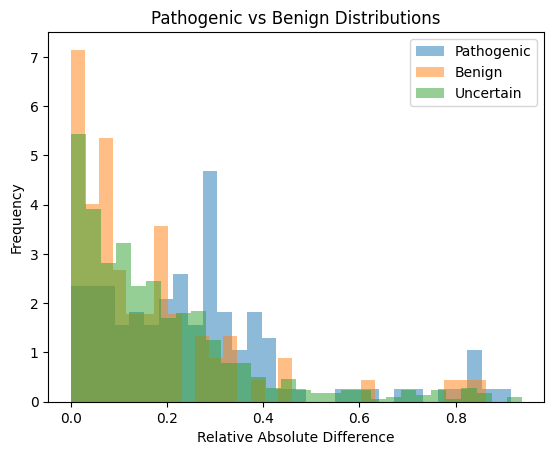

In [ ]:
pathogenic_distr = pathogenic['relative_abs_diff']
benign_distr = benign['relative_abs_diff']
uncertain_distr = uncertain['relative_abs_diff']

plt.hist(pathogenic_distr, bins=30, alpha=0.5, label='Pathogenic', density=True)
plt.hist(benign_distr, bins=30, alpha=0.5, label='Benign', density=True)
plt.hist(uncertain_distr, bins=30, alpha=0.5, label='Uncertain', density=True)

plt.title('Pathogenic vs Benign Distributions')
plt.xlabel('Relative Absolute Difference')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test for both orders
u_stat1, p_value1 = mannwhitneyu(pathogenic_distr, benign_distr)
u_stat2, p_value2 = mannwhitneyu(benign_distr, pathogenic_distr)

# Sizes of both groups
n1 = len(pathogenic_distr)
n2 = len(benign_distr)

# Rank-biserial correlation for the first order
rank_biserial1 = (2 * u_stat1 - n1 * n2) / (n1 * (n1 + n2))

# Rank-biserial correlation for the second order (flipped)
rank_biserial2 = (2 * u_stat2 - n1 * n2) / (n1 * (n1 + n2))

# Print the correct rank-biserial correlation
print(f"Rank-biserial correlation for first order (pathogenic vs benign): {rank_biserial1}")
print(f"Rank-biserial correlation for second order (benign vs pathogenic): {rank_biserial2}")

# Determine which distribution tends to have larger values
if u_stat1 < n1 * n2 / 2:
    print("Pathogenic distribution tends to have smaller values than Benign.")
else:
    print("Pathogenic distribution tends to have larger values than Benign.")

# Interpretation of p-value
if p_value1 < 0.05:
    print("The difference is statistically significant for first order (pathogenic vs benign).")
else:
    print("No significant difference for first order.")

if p_value2 < 0.05:
    print("The difference is statistically significant for second order (benign vs pathogenic).")
else:
    print("No significant difference for second order.")


Rank-biserial correlation for first order (pathogenic vs benign): 0.1503267973856209
Rank-biserial correlation for second order (benign vs pathogenic): -0.1503267973856209
Pathogenic distribution tends to have larger values than Benign.
The difference is statistically significant for first order (pathogenic vs benign).
The difference is statistically significant for second order (benign vs pathogenic).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_seq_distr(seq_id, plot=False):
  # Filter the dataframe for the desired `seq_id`
  seq_id_value = seq_id  # Replace with your target seq_id
  filtered_df = clinvar_ss[clinvar_ss['seq_id'] == seq_id_value].copy()

  # Define the mutation type based on `ClinicalSignificance`
  def categorize_significance(value):
      if pd.notnull(value):
          value = value.lower()
          if 'pathogen' in value:
              return 'Pathogenic'
          elif 'benign' in value:
              return 'Benign'
          elif 'uncertain' in value:
              return 'Uncertain'
      return 'Other'

  filtered_df.loc[:, 'MutationType'] = filtered_df['ClinicalSignificance'].apply(categorize_significance)

  # Filter only benign, pathogenic, and uncertain mutations
  mutation_df = filtered_df[filtered_df['MutationType'].isin(['Pathogenic', 'Benign', 'Uncertain'])]

  # Violin Plot
  if(plot):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=mutation_df, x='MutationType', y='score', hue='MutationType', palette='Set1', inner="quartile", legend=False)
    plt.title(f'Score Distribution by Mutation Type for seq_id {seq_id_value}')
    plt.show()

for seq_id in clinvar_ss['seq_id'].unique():
  plot_seq_distr(seq_id, False)


In [ ]:
import pandas as pd

# Assuming `clinvar_ss` is your DataFrame
dfoi = pathogenic
dfoi['abs_diff'] = (dfoi['score'] - dfoi['original_score']).abs()

# Find the row with the maximum absolute difference for each seq_id
result = dfoi.loc[dfoi.groupby('seq_id')['abs_diff'].idxmax()]

# sort by abs_diff (largest first)
result = result.sort_values(by='abs_diff', ascending=False)

# Display the result
display(result)
result.to_csv("/content/annotated_clinical_variants_pathogenic_with_jxt.csv")

<ipython-input-102-5243a0cd2c55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfoi['abs_diff'] = (dfoi['score'] - dfoi['original_score']).abs()


,Unnamed: 0.1,Unnamed: 0,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,position,seq_id,Sequence,Transmembrane,tm_seq,tm_seq_original,score,original_score,relative_abs_diff,abs_diff
2254,2254,5016,363580,single nucleotide variant,NM_001281766.3(EPHA5):c.1748G>A (p.Gly583Glu),2044,EPHA5,HGNC:3389,Likely pathogenic,1,"May 13, 2016",1057520012,-,RCV000432246,"Human Phenotype Ontology:HP:0030078,MONDO:MONDO:0005061,MeSH:D000077192,MedGen:C0152013",Lung adenocarcinoma,somatic,somatic,GRCh37,NC_000004.11,4,66270137,66270137,na,na,4q13.1,no assertion criteria provided,1,-,N,ClinGen:CA16603113,1,376701,66270137,C,T,1748.0,P54756,MRGSGPRGAGRRRPPSGGGDTPITPASLAGCYSAPRRAPLWTCLLLCAALRTLLASPSNEVNLLDSRTVMGDLGWIAFPKNGWEEIGEVDENYAPIHTYQVCKVMEQNQNNWLLTSWISNEGASRIFIELKFTLRDCNSLPGGLGTCKETFNMYYFESDDQNGRNIKENQYIKIDTIAADESFTELDLGDRVMKLNTEVRDVGPLSKKGFYLAFQDVGACIALVSVRVYYKKCPSVVRHLAVFPDTITGADSSQLLEVSGSCVNHSVTDEPPKMHCSAEGEWLVPIGKCMCKAGYEEKNGTCQVCRPGFFKASPHIQSCGKCPPHSYTHEEASTSCVCEKDYFRRESDPPTMACTRPPSAPRNAISNVNETSVFLEWIPPADTGGRKDVSYYIACKKCNSHAGVCEECGGHVRYLPRQSGLKNTSVMMVDLLAHTNYTFEIEAVNGVSDLSPGARQYVSVNVTTNQAAPSPVTNVKKGKIAKNSISLSWQEPDRPNGIILEYEIKYFEKDQETSYTIIKSKETTITAEGLKPASVYVFQIRARTAAGYGVFSRRFEFETTPVFAASSDQSQIPVIAVSVTVGVILLAVVIGVLLSGSCCECGCGRASSLCAVAHPSLIWRCGYSKAKQDPEEEKMHFHNGHIKLPGVRTYIDPHTYEDPNQAVHEFAKEIEASCITIERVIGAGEFGEVCSGRLKLPGKRELPVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIHLEGVVTKSKPVMIVTEYMENGSLDTFLKKNDGQFTVIQLVGMLRGISAGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTAPEAIAFRKFTSASDVWSYGIVMWEVVSYGERPYWEMTNQDVIKAVEEGYRLPSPMDCPAALYQLMLDCWQKERNSRPKFDEIVNMLDKLIRNPSSLKTLVNASCRVSNLLAEHSPLGSGAYRSVGEWLEAIKMGRYTEIFMENGYSSMDAVAQVTLEDLRRLGVTLVGHQKKIMNSLQEMKVQLVNGMVPL,"(574, 594)",IAVSVTVGEILLAVVIGVLLSGSCCECG,IAVSVTVGVILLAVVIGVLLSGSCCECG,2.706349,20.766470,0.869677,18.060121
262,262,919,1274573,single nucleotide variant,NM_000527.5(LDLR):c.2414G>A (p.Gly805Glu),3949,LDLR,HGNC:6547,Likely pathogenic,1,-,-1,-,RCV001699871,MedGen:CN517202,not provided,germline,germline,GRCh37,NC_000019.9,19,11240213,11240213,na,na,19p13.2,no assertion criteria provided,2,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",N,-,2,1284721,11240213,G,A,2414.0,P01130,MGPWGWKLRWTVALLLAAAGTAVGDRCERNEFQCQDGKCISYKWVCDGSAECQDGSDESQETCLSVTCKSGDFSCGGRVNRCIPQFWRCDGQVDCDNGSDEQGCPPKTCSQDEFRCHDGKCISRQFVCDSDRDCLDGSDEASCPVLTCGPASFQCNSSTCIPQLWACDNDPDCEDGSDEWPQRCRGLYVFQGDSSPCSAFEFHCLSGECIHSSWRCDGGPDCKDKSDEENCAVATCRPDEFQCSDGNCIHGSRQCDREYDCKDMSDEVGCVNVTLCEGPNKFKCHSGECITLDKVCNMARDCRDWSDEPIKECGTNECLDNNGGCSHVCNDLKIGYECLCPDGFQLVAQRRCEDIDECQDPDTCSQLCVNLEGGYKCQCEEGFQLDPHTKACKAVGSIAYLFFTNRHEVRKMTLDRSEYTSLIPNLRNVVALDTEVASNRIYWSDLSQRMICSTQLDRAHGVSSYDTVISRDIQAPDGLAVDWIHSNIYWTDSVLGTVSVADTKGVKRKTLFRENGSKPRAIVVDPVHGFMYWTDWGTPAKIKKGGLNGVDIYSLVTENIQWPNGITLDLLSGRLYWVDSKLHSISSIDVNGGNRKTILEDEKRLAHPFSLAVFEDKVFWTDIINEAIFSANRLTGSDVNLLAENLLSPEDMVLFHNLTQPRGVNWCERTTLSNGGCQYLCLPAPQINPHSPKFTCACPDGMLLARDMRSCLTEAEAAVATQETSTVRLKVSSTAVRTQHTTTRPVPDTSRLPGATPGLTTVEIVTMSHQALGDVAGRGNEKKPSSVRALSIVLPIVLLVFLCLGVFLLWKNWRLKNINSINFDNPVYQKTTEDEVHICHNQDGYSYPSRQMVSLEDDVA,"(789, 810)",LSIVLPIVLLVFLCLEVFLLWKNWRLKNI,LSIVLPIVLLVFLCLGVFLLWKNWRLKNI,1.382449,16.304964,0.915213,14.922515
1540,1540,4009,860470,single nucleotide variant,NM_001942.4(DSG1):c.1684G>A (p.Gly562Arg),1828,DSG1,HGNC:3048,Conflicting interpretations of pathogenicity,1,"Oct 14, 2022",2071779127,-,RCV001092835|RCV003389066,"MedGen:C3661900|MONDO:MONDO:0007859,MedGen:C2931122,OMIM:148700,Orphanet:369999,Orphanet:370002","not provided|Palmoplantar keratoderma i, striate, focal, or diffuse",germline,germline,GRCh37,NC_000018.9,18,28919985,28919985,na,na,18q12.1,"criteria provided, conflicting interpretations",3,-,N,-,2,872392

## Endogenous Protease Activity

In [ ]:
import pandas as pd

def extract_membrane_indices(transmembrane_string):
    # Initialize an empty list to store the indices
    indices = []

    # Iterate through the string
    splits = transmembrane_string.split('TRANSMEM')
    for split in splits:
      indices_instance = split.strip()
      indices_instance = indices_instance.split('..')
      try:
        indices_instance[1] = indices_instance[1].split(';')[0]
        indices.append(tuple(indices_instance))
      except:
        continue

    return indices

def extract_seqs(uniprot_df):
  sequences = []
  for indx, row in uniprot_df.iterrows():
    for tm_index in row['tm_indices']:
      try:
        sequences.append(row['Sequence'][int(tm_index[0]):int(tm_index[1])])
      except:
        pass
  return sequences

uniprot_df = pd.read_csv('/content/idmapping_2024_10_07.tsv', sep='\t', on_bad_lines='skip')
uniprot_df['tm_indices'] = uniprot_df['Transmembrane'].apply(lambda x: extract_membrane_indices(x))
tm_df = pd.read_csv('/content/tm_library_annotated.csv')
sequences = set((extract_seqs(uniprot_df)) + (tm_df['aa_seq'].values.tolist()))


In [ ]:
# parse substrate seqs for intramembrane TMs
import re
motifs_of_interest = ['GXXX'] #'GXGD', 'RSVLS', 'GXXXG', 'HEXXH', 'RSVLS', 'CGGX', 'CAAX', 'CVVX', 'CLLX', 'CIIX', 'CPPX']

def find_motifs(sequences, motif):
    # Convert the motif pattern, where X is any character
    motif_regex = motif.replace('X', '.')  # '.' in regex matches any character
    pattern = re.compile(motif_regex)

    result = []
    for seq in sequences:
        matches = [(m.start(), m.group()) for m in pattern.finditer(seq)]
        if matches:
            result.append((seq, matches))
    return result

In [ ]:
hits = []
for motif_of_interest in motifs_of_interest:
  hits += find_motifs(sequences, motif_of_interest)

hits_to_ala_scan = {}
hits_to_random_scan = {}

for hit in hits:

  roi = 'G'
  num_to_replace = 1

  motif = hit[1][0][1]
  len_motif = len(motif)
  mutagenesis = motif.replace(roi, 'A') if num_to_replace is None else motif.replace(roi, 'A', num_to_replace)
  insert_pos = hit[1][0][0]
  new_seq = hit[0][:insert_pos] + mutagenesis + hit[0][insert_pos+len_motif:]

  num_replacements = motif.count(roi) if num_to_replace is None else num_to_replace
  random_start_pos = np.random.randint(0, len(hit[0])-num_replacements)
  random_seq = hit[0][:random_start_pos] + 'A'*num_replacements + hit[0][random_start_pos+num_replacements:]

  hits_to_ala_scan[hit[0]] = new_seq
  hits_to_random_scan[hit[0]] = random_seq

original_seqs = list(hits_to_ala_scan.keys())
new_seqs = list(hits_to_ala_scan.values())
random_seqs = list(hits_to_random_scan.values())
print(hits)

[('FSTCSSHLCVVGLFFGSAIVTY', [(11, 'GLFF'), (15, 'GSAI')]), ('IVPLFVAFSTIGAANGTCFTAG', [(11, 'GAAN'), (15, 'GTCF')]), ('LCLGSFQGLVVAVLYCFLNSEVQCELKR', [(3, 'GSFQ'), (7, 'GLVV')]), ('QVLDAFLCAVGLTSYSVLVI', [(10, 'GLTS')]), ('VGVCITAAVALHYFLLVSFTWMGLEAVHM', [(1, 'GVCI'), (22, 'GLEA')]), ('LFFFVVFVVAEGYLLTAMAY', [(11, 'GYLL')]), ('VALYCALCFTVSAVASLVCLLRHGGRTVE', [(23, 'GGRT')]), ('PPGVIALVNFLGPLLFTFLV', [(2, 'GVIA'), (11, 'GPLL')]), ('YPEYFVFTGVLAMVTCAVFL', [(8, 'GVLA')]), ('VSLGIAGILIVLSSVACSLGVFLYCNHRNR', [(3, 'GIAG'), (19, 'GVFL')]), ('STCGSHIGIILVFYIPAFFS', [(3, 'GSHI'), (7, 'GIIL')]), ('VLWGPVLGALLVVIAGYLCL', [(3, 'GPVL'), (7, 'GALL'), (15, 'GYLC')]), ('FGTGIAMSTWVWTKATLLIW', [(1, 'GTGI')]), ('GLAMLSVGIGIDYTHIEVLI', [(0, 'GLAM'), (7, 'GIGI')]), ('MLGVCWVLTNCPALMHTLLL', [(2, 'GVCW')]), ('VYGVAAGAFVLLIFIVSMIYLACKKPKKP', [(2, 'GVAA'), (6, 'GAFV')]), ('FWVLVVVGGVAACYSLLVTVAFIIFWV', [(7, 'GGVA')]), ('YLYVATLIIMGLALCAIPFA', [(10, 'GLAL')]), ('SFQLICSYILRPVAFLMGVAW', [(17, 'GVAW')]), ('FIWGF

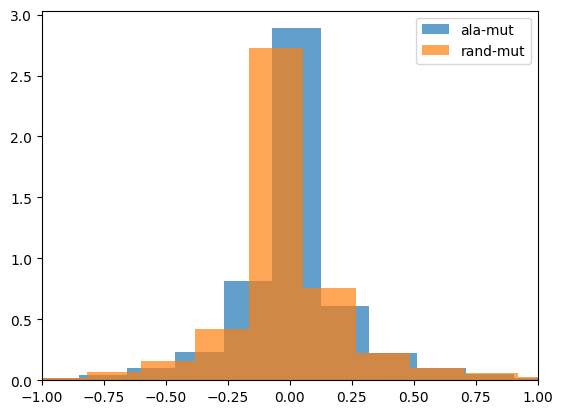

In [ ]:
max_length = 40
probs_wt = linear_model(np.array(get_sequence_probs(original_seqs, model, tokenizer, max_length, device).tolist()), *params)
probs_ala_mut = linear_model(np.array(get_sequence_probs(new_seqs, model, tokenizer, max_length, device).tolist()), *params)
probs_random_mut = linear_model(np.array(get_sequence_probs(random_seqs, model, tokenizer, max_length, device).tolist()), *params)

probs_ala_delta = probs_ala_mut - probs_wt
probs_random_delta = probs_random_mut - probs_wt

# plot distribution
plt.hist(probs_ala_delta, bins=20, label='ala-mut', alpha=0.7, density=True)
plt.hist(probs_random_delta, bins=20, label='rand-mut', alpha=0.7, density=True)
plt.xlim(-1, 1)  # Replace with appropriate values based on your data
plt.legend()
plt.show()


In [ ]:
from scipy import stats

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(probs_ala_delta, probs_random_delta, )

print(f"K-S test statistic: {ks_statistic}")
print(f"P-value: {p_value}")

print(f"Mean of probs_ala_delta: {np.mean(probs_ala_delta)}, median of probs_ala_delta: {np.median(probs_ala_delta)}")
print(f"Mean of probs_random_delta: {np.mean(probs_random_delta)}, , median of probs_random_delta: {np.median(probs_random_delta)}")

K-S test statistic: 0.10083719938143232
P-value: 1.8939081060811577e-83
Mean of probs_ala_delta: 0.018785692874883058, median of probs_ala_delta: 0.005407053844008303
Mean of probs_random_delta: 0.006594695717354581, , median of probs_random_delta: 0.0


In [ ]:
## cutsite introduction
with_cutsite_seqs = []
original_seqs = []
for hit in hits:
  original_seq = hit[0]
  cutsite_pos = hit[1][0][0]
  with_cutsite = original_seq[:cutsite_pos+3] + 'G' + original_seq[cutsite_pos+4:]
  with_cutsite_seqs.append(with_cutsite)
  original_seqs.append(original_seq)

cutsite_scores = linear_model(np.array(get_sequence_probs(with_cutsite_seqs, model, tokenizer, max_length, device).tolist()), *params)
original_scores = linear_model(np.array(get_sequence_probs(original_seqs, model, tokenizer, max_length, device).tolist()), *params)

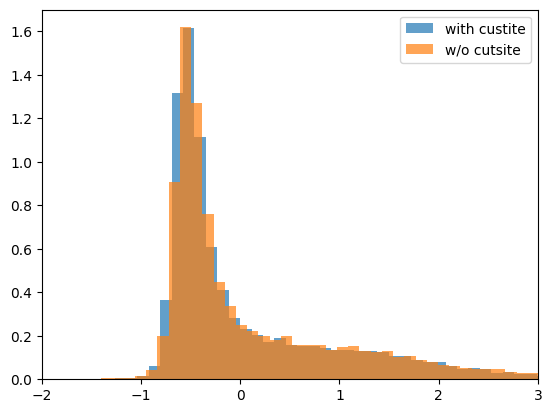

K-S test statistic: 0.02730229829893882
P-value: 1.666017152953408e-06
Mean of cut-site scores: 0.04193099686465531, median of cut-site scores: -0.36879803459474525
Mean of original scores: 0.088129062004898, median of original scores: -0.34105271208110643


In [ ]:
from scipy import stats


# plot distribution
plt.hist(cutsite_scores, bins=50, label='with custite', alpha=0.7, density=True)
plt.hist(original_scores, bins=50, label='w/o cutsite', alpha=0.7, density=True)
plt.xlim(-2, 3)  # Replace with appropriate values based on your data
plt.legend()
plt.show()

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(cutsite_scores, original_scores, )

print(f"K-S test statistic: {ks_statistic}")
print(f"P-value: {p_value}")

print(f"Mean of cut-site scores: {np.mean(cutsite_scores)}, median of cut-site scores: {np.median(cutsite_scores)}")
print(f"Mean of original scores: {np.mean(original_scores)}, median of original scores: {np.median(original_scores)}")

## Attention inspection


In [ ]:
def get_embedding(sequences, max_length=40):

  tokens = tokenizer(sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt").to(device)
  input_ids = tokens["input_ids"]
  attention_mask = tokens["attention_mask"]
  embeddings = model.esm.embeddings(input_ids, attention_mask)
  #print(embeddings.shape)

  return embeddings

def get_param_by_name(model, param_name):
    for name, param in model.named_parameters():
        if name == param_name:
            return param
    print(f"Error fetching param: {param_name}")
    return None  # If the parameter name is not found

def compute_attention(model, x):
  layers = model_size[0]
  attention_sum = None
  for layer_indx in range(layers):
    attention = model.esm.encoder.layer[layer_indx].attention(x)
    attention_sum = attention[0] if attention_sum is None else attention_sum + attention[0]
    return attention[0]/layers



# out = get_param_by_name(model, "esm.encoder.layer.0.attention.self.original_layer.weight")
# print(out)

In [ ]:
# sequence = 'GLGDFIFYSVLVGKASATAS'
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attention_heatmap):
  # Plot the heatmap
  plt.figure(figsize=(12, 8))
  plt.imshow(attention_heatmap, aspect='auto', cmap='viridis')

  # Add color bar
  plt.colorbar()

  # Add labels and title
  plt.xlabel('Token positions')
  plt.ylabel('Attention value')
  plt.title('Heatmap of Token Attentions')

  # Display the plot
  plt.show()

def get_relative_attention_scores(sequence, indexes=None, ignore_padding=True):
  embedding = get_embedding([sequence])
  attention = compute_attention(model, embedding)
  if(ignore_padding):
    attention_heatmap = attention[:, 0:len(sequence), :]
  else:
    attention_heatmap = attention
  attention_heatmap = torch.sum(attention_heatmap, dim=2).detach().cpu()

  if(indexes):
    ln = len(indexes[1])
    avg_for_cutsite = np.average((attention_heatmap[:, indexes[0]:indexes[0]+ln]))
    avg_overall = np.average(attention_heatmap)
    return avg_for_cutsite, avg_overall
  else:
    return attention_heatmap


In [ ]:
cutsite_averages = []
overall_averages = []
for hit in hits:
  sequence = hit[0]
  indexes = hit[1][0]
  avg_for_cutsite, avg_overall = get_relative_attention_scores(sequence, indexes)
  cutsite_averages.append(avg_for_cutsite)
  overall_averages.append(avg_overall)


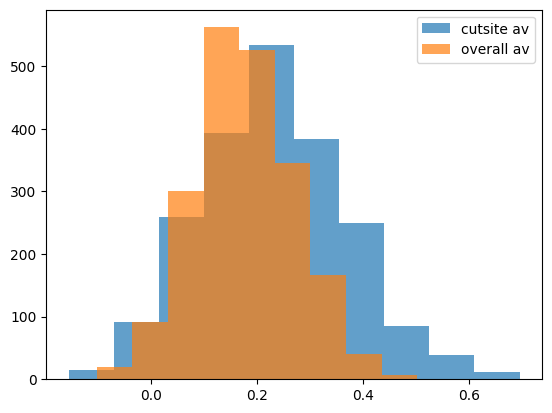

In [ ]:
plt.hist(cutsite_averages, label='cutsite av', alpha=0.7)
plt.hist(overall_averages, label='overall av', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
from scipy import stats

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(cutsite_averages, overall_averages, )

print(f"K-S test statistic: {ks_statistic}")
print(f"P-value: {p_value}")

print(f"Mean of probs_ala_delta: {np.mean(cutsite_averages)}, median of probs_ala_delta: {np.median(cutsite_averages)}")
print(f"Mean of probs_random_delta: {np.mean(overall_averages)}, , median of probs_random_delta: {np.median(overall_averages)}")

K-S test statistic: 0.21699029126213593
P-value: 7.084337100767199e-43
Mean of probs_ala_delta: 0.23170801997184753, median of probs_ala_delta: 0.22690638899803162
Mean of probs_random_delta: 0.17720721662044525, , median of probs_random_delta: 0.1713344305753708


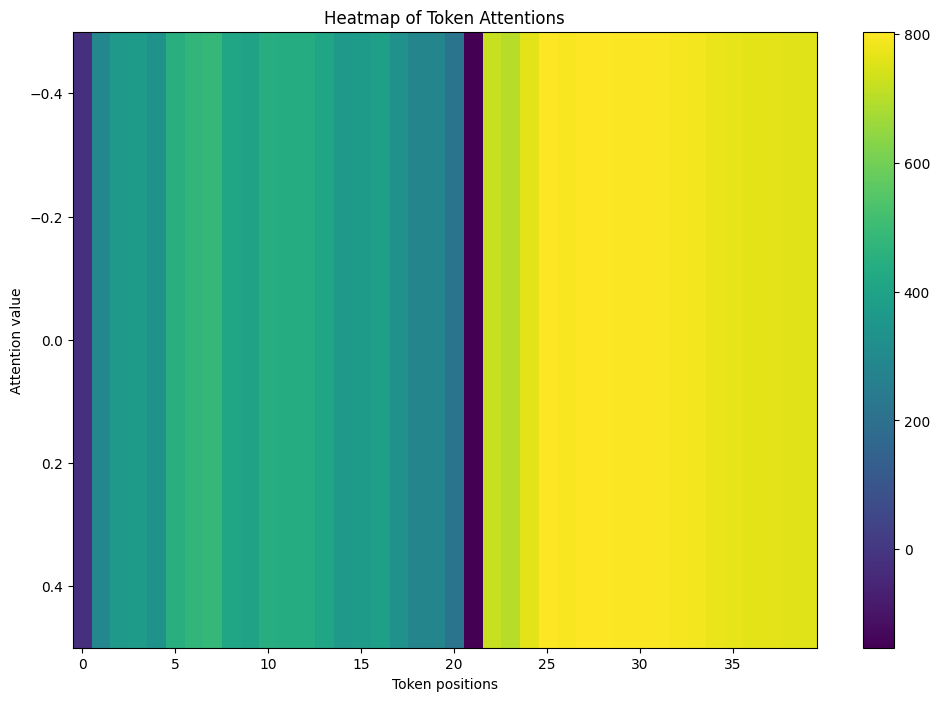

In [ ]:
heat_map_sum = None
for hit in hits:
  sequence = hit[0]
  indexes = hit[1][0]
  heat_map = get_relative_attention_scores(sequence, None, False)
  heat_map_sum = heat_map if heat_map_sum is None else heat_map_sum + heat_map

plot_attention(heat_map_sum)


## Deep Mutational Scanning for CD3 TM

In [ ]:
# Function to generate all single amino acid variants
def generate_variants(sequence, amino_acids):
    variants = []

    # Substitutions: Replace each amino acid with another one
    for i, original_aa in enumerate(sequence):
        for aa in amino_acids:
            if aa != original_aa:  # Avoid substituting with the same amino acid
                variant = sequence[:i] + aa + sequence[i + 1:]
                variants.append(("substitution", i, original_aa, aa, variant))

    # Insertions: Insert each amino acid at every position
    # for i in range(len(sequence) + 1):  # Include one extra position for appending
    #     for aa in amino_acids:
    #         variant = sequence[:i] + aa + sequence[i:]
    #         variants.append(("insertion", i, "-", aa, variant))

    # # Deletions: Remove each amino acid one at a time
    # for i, original_aa in enumerate(sequence):
    #     variant = sequence[:i] + sequence[i + 1:]
    #     variants.append(("deletion", i, original_aa, "-", variant))

    return variants

In [ ]:
#
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
cart_tm_seq_jxt = "VMSVATIVIVDICITGGLLLLVYYWS" + "KNRKAKAK"
# cd3d GIIVTDVIATLLLALGVFCFA + GHETGRLS
# cd3g GFLFAEIVSIFVLAVGVYFIA + GQDGVRQS
# cd3z LCYLLDGILFIYGVILTALFL + RVKFSRSA
# cd3e VMSVATIVIVDICITGGLLLLVYYWS + KNRKAKAK
# Generate variants
variants = generate_variants(cart_tm_seq_jxt, amino_acids)

# Print the total number of variants and a few examples
print(f"Total variants generated: {len(variants)}")
print("Example variants:")
for variant in variants[:5]:  # Show a few examples
    print(variant)

seqs = [variant[4] for variant in variants]
scores = np.exp(linear_model(np.array(get_sequence_probs(seqs, model, tokenizer, max_length, device).tolist()), *params))
scores_diff = scores - np.exp(linear_model(np.array(get_sequence_probs([cart_tm_seq_jxt], model, tokenizer, max_length, device).tolist()), *params))

Total variants generated: 646
Example variants:
('substitution', 0, 'V', 'A', 'AMSVATIVIVDICITGGLLLLVYYWSKNRKAKAK')
('substitution', 0, 'V', 'C', 'CMSVATIVIVDICITGGLLLLVYYWSKNRKAKAK')
('substitution', 0, 'V', 'D', 'DMSVATIVIVDICITGGLLLLVYYWSKNRKAKAK')
('substitution', 0, 'V', 'E', 'EMSVATIVIVDICITGGLLLLVYYWSKNRKAKAK')
('substitution', 0, 'V', 'F', 'FMSVATIVIVDICITGGLLLLVYYWSKNRKAKAK')


In [ ]:
# make df of sequence, substitution information, and score diff, sort by scores diff

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to avoid truncation
pd.set_option('display.max_colwidth', None)  # Avoid truncating column content

df = pd.DataFrame(variants, columns=["Operation", "Position", "Original", "New", "Sequence"])
df["Score Difference"] = scores_diff
df = df.sort_values(by="Score Difference", ascending=False)
df = df.reset_index(drop=True)
display(df)
df.to_csv("/content/cd3e_tm_variants_with_jxt.csv")

,Operation,Position,Original,New,Sequence,Score Difference
0,substitution,10,D,V,VMSVATIVIVVICITGGLLLLVYYWSKNRKAKAK,3.432143
1,substitution,10,D,C,VMSVATIVIVCICITGGLLLLVYYWSKNRKAKAK,3.024261
2,substitution,10,D,S,VMSVATIVIVSICITGGLLLLVYYWSKNRKAKAK,3.001736
3,substitution,10,D,I,VMSVATIVIVIICITGGLLLLVYYWSKNRKAKAK,2.987873
4,substitution,10,D,A,VMSVATIVIVAICITGGLLLLVYYWSKNRKAKAK,2.951382
5,substitution,10,D,G,VMSVATIVIVGICITGGLLLLVYYWSKNRKAKAK,2.740604
6,substitution,10,D,P,VMSVATIVIVPICITGGLLLLVYYWSKNRKAKAK,2.735426
7,substitution,10,D,L,VMSVATIVIVLICITGGLLLLVYYWSKNRKAKAK,2.664903
8,substitution,10,D,T,VMSVATIVIVTICITGGLLLLVYYWSKNRKAKAK,2.632391
9,substitution,10,D,M,VMSVATIVIVMICITGGLLLLVYYWSKNRKAKAK,2.451841
